# Project Flow Chart

The `main.ipynb` is an interactive notebook with EDA + model training and inference, i.e. a quick and reproducable example. The complete project is available on [GitHub](https://github.com/ghginm/Air-Quality-Forecasting-System). Here is a simplified flow chart for the project:

![graph.png](./eda/graph.png)

# EDA

In [1]:
import json
import math
import random
import warnings
from itertools import chain
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import IterativeImputer
from statsmodels.graphics import tsaplots

import model_creation.training_testing as training_testing
import model_creation.tuning_cv as tuning_cv
import utils.data_utils as data_utils


warnings.filterwarnings("ignore")

sns.set_theme(rc={'grid.linewidth': 0.6, 'grid.color': 'white',
                  'axes.linewidth': 2, 'axes.facecolor': '#ECECEC', 
                  'axes.labelcolor': '#000000',
                  'figure.facecolor': 'white',
                  'xtick.color': '#000000', 'ytick.color': '#000000'})

## I. Data understanding: data quality and EDA

### 1. Loading data

In [2]:
## Initial parameters

# Paths
path_project = str(Path('__file__').absolute().parent)

## Data

# Loading data
data = pd.read_csv(f'{path_project}\\data\\city_pollution_data.csv')

# Prliminary data cleaning
data = data.rename(columns={'Population Staying at Home': 'Pop_at_home', 
                            'Population Not Staying at Home': 'Pop_not_at_home'})

data['Pop_at_home'] = data['Pop_at_home'].str.replace(',', '').astype(int)
data['Pop_not_at_home'] = data['Pop_not_at_home'].str.replace(',', '').astype(int)

# Reduce memory usage
data = data_utils.squeeze_df(df=data)
data['Date'] = pd.to_datetime(data['Date'])

# Target variable (dropping irrelevant pollutants)
pollutants_target = 'pm25_median'
pollutants_drop = ['o3', 'no2_', 'pm10_', 'co_', 'so2_', 'pm25_']
pollutants_drop = [x for x in data.columns if any(x_drop in x for x_drop in pollutants_drop)]
pollutants_drop = list(set(pollutants_drop) - {'pm25_median'})

data = data.drop(columns=pollutants_drop, axis=1)

# Sorting data
data = data.sort_values(by=['City', 'Date']).reset_index(drop=True)

### 2. Data quality: assessment

In [3]:
# Continuous features
continuous_features = data.columns[4:]
data_utils.continuous_features_report(df=data, continuous_features=continuous_features)

Mean     Median         Std  N observations  \
dew_count                  31.66      24.00       17.05         20491.0   
dew_variance               52.92      23.10      169.64         20491.0   
dew_min                     6.82       7.00        9.66         20491.0   
dew_max                    13.04      14.00        8.67         20491.0   
dew_median                 10.01      11.00        8.92         20491.0   
wind-gust_min               0.67       0.20        1.65         34217.0   
wind-gust_max              14.48      13.00        7.95         34217.0   
wind-gust_median            5.34       4.60        3.19         34217.0   
wind-gust_variance        154.27     106.34      389.35         34217.0   
wind-gust_count            81.16      66.00       54.24         34217.0   
wind-speed_median           2.36       2.00        2.39         34646.0   
wind-speed_max              7.66       6.50        6.16         34646.0   
wind-speed_min              0.28       0.10        1.68         34646.0   
wind-speed_count           81.10      65.00       52.91         34646.0   
wind-speed_variance        55.35      24.65      514.40         34646.0   
temperature_max            23.22      24.80       11.98         34658.0   
temperature_count         102.33      72.00       57.60         34658.0   
temperature_variance      229.34     137.22      606.18         34658.0   
temperature_median         15.76      17.00        9.63         34658.0   
temperature_min             9.21      10.20       10.65         34658.0   
humidity_count            102.36      72.00       57.83         34668.0   
humidity_median            64.29      69.80       22.57         34668.0   
humidity_max               88.28      94.00       16.79         34668.0   
humidity_min               36.89      38.10       21.99         34668.0   
pressure_count            103.53      72.00       58.11         34667.0   
pressure_variance       78065.44      65.48   337973.33         34667.0   
pressure_median          1003.66    1015.20      107.81         34667.0   
pressure_max             1023.24    1019.90       40.84         34667.0   
pressure_min              949.85    1009.70      220.72         34667.0   
humidity_variance        2660.05    1920.59     2903.24         34668.0   
pm25_median                31.15      28.00       17.11         35134.0   
Pop_at_home            337261.34  219644.00   382085.15         35596.0   
Pop_not_at_home       1124679.30  738718.00  1256587.42         35596.0   
longitude                 -97.17     -93.10       18.31         35596.0   
latitude                   37.09      37.55        5.23         35596.0   
past_week_avg_miles         0.00       0.00        0.00         35596.0   
mil_miles                  46.86      31.17       52.96         35596.0   
pp_feat                     8.44       1.77       24.63         35596.0   

                      Missing values %  Cardinality       Min  1st Quartile  \
dew_count                        42.43        122.0      2.00         20.00   
dew_variance                     42.43       8738.0      0.00         10.70   
dew_min                          42.43        303.0   -110.50          0.50   
dew_max                          42.43        290.0    -22.70          7.00   
dew_median                       42.43        270.0    -26.00          3.00   
wind-gust_min                     3.87        135.0      0.10          0.10   
wind-gust_max                     3.87        547.0      0.10          9.70   
wind-gust_median                  3.87        235.0      0.10          3.00   
wind-gust_variance                3.87      20540.0      0.00         59.66   
wind-gust_count                   3.87        306.0      2.00         43.00   
wind-speed_median                 2.67        133.0      0.00          1.30   
wind-speed_max                    2.67        373.0      0.00          4.60   
wind-speed_min                    2.67         69.0      0.00          0.10

In [4]:
# Categorical features
categorical_features = data.columns[:4]
data_utils.categorical_features_report(df=data, categorical_features=categorical_features)

N observations  Missing values %  Cardinality
Date           35596.0               0.0        668.0
City           35596.0               0.0         54.0
County         35596.0               0.0         53.0
State          35596.0               0.0         34.0

In [5]:
# Additional info necessary for EDA
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year

cities_list = list(data['City'].unique())
states_list = list(data['State'].unique())

In [6]:
# NaNs by city
nulls = data.isnull().sum()
nulls = nulls[nulls > 0].index

nulls_group = data.groupby('City', as_index=False)[nulls].apply(lambda x: x.isnull().sum())
nulls_group_perc = nulls_group.iloc[:, 1:].div(data.groupby('City', as_index=False)['Date'].count()['Date'], axis=0)
nulls_group_perc['City'] = nulls_group['City']
nulls_group_perc = pd.melt(nulls_group_perc, id_vars=['City']).sort_values(by='value')

# Dropping variable `dew` (it has over 40% of NaNs)
nulls_group_perc = nulls_group_perc[~nulls_group_perc['variable'].str.contains('dew')]

# Cities with more than 10% of NaNs
nulls_group_perc_high_nan = nulls_group_perc[nulls_group_perc['value'] >= 0.05]
nulls_group_perc_high_nan

City              variable     value
640     san diego       temperature_min  0.065104
586     san diego        humidity_count  0.065104
424     san diego          humidity_max  0.065104
802     san diego  temperature_variance  0.065104
1612    san diego    wind-gust_variance  0.065104
748     san diego    temperature_median  0.065104
1666    san diego       wind-gust_count  0.065104
478     san diego       humidity_median  0.065104
370     san diego          humidity_min  0.065104
532     san diego     humidity_variance  0.065104
1450    san diego         wind-gust_min  0.065104
1558    san diego      wind-gust_median  0.065104
1504    san diego         wind-gust_max  0.065104
154     san diego       pressure_median  0.065104
694     san diego       temperature_max  0.065104
46      san diego          pressure_min  0.065104
208     san diego     pressure_variance  0.065104
262     san diego        pressure_count  0.065104
856     san diego     temperature_count  0.065104
100     san diego          pressure_max  0.065104
1288    san diego     wind-speed_median  0.067708
1180    san diego        wind-speed_min  0.067708
1234    san diego        wind-speed_max  0.067708
1342    san diego   wind-speed_variance  0.067708
1396    san diego      wind-speed_count  0.067708
1305     columbia   wind-speed_variance  0.069091
1251     columbia     wind-speed_median  0.069091
1143     columbia        wind-speed_min  0.069091
1359     columbia      wind-speed_count  0.069091
1197     columbia        wind-speed_max  0.069091
1476     honolulu         wind-gust_max  0.101796
1584     honolulu    wind-gust_variance  0.101796
1638     honolulu       wind-gust_count  0.101796
1530     honolulu      wind-gust_median  0.101796
1422     honolulu         wind-gust_min  0.101796
1636       fresno       wind-gust_count  0.134731
1420       fresno         wind-gust_min  0.134731
1474       fresno         wind-gust_max  0.134731
1582       fresno    wind-gust_variance  0.134731
1528       fresno      wind-gust_median  0.134731
1637     hartford       wind-gust_count  0.148204
1529     hartford      wind-gust_median  0.148204
1583     hartford    wind-gust_variance  0.148204
1475     hartford         wind-gust_max  0.148204
1421     hartford         wind-gust_min  0.148204
1473   fort worth         wind-gust_max  0.182504
1581   fort worth    wind-gust_variance  0.182504
1419   fort worth         wind-gust_min  0.182504
1527   fort worth      wind-gust_median  0.182504
1635   fort worth       wind-gust_count  0.182504
310      richmond           pm25_median  0.211094
1428  little rock         wind-gust_min  0.245509
1590  little rock    wind-gust_variance  0.245509
1536  little rock      wind-gust_median  0.245509
1644  little rock       wind-gust_count  0.245509
1482  little rock         wind-gust_max  0.245509
279      columbia           pm25_median  0.420000

### 3. EDA: spatio-temporal patterns

#### 3.1 Trend analysis (temporal)

In [7]:
data.groupby(['year'], as_index=False)[pollutants_target].agg(['median', 'mean', 
                                                               'std', 'min', 'max']).round(3)

year  median    mean     std  min    max
0  2019    28.0  30.541  13.758  1.0  147.0
1  2020    28.0  31.777  19.923  3.0  507.0

In [8]:
data.groupby('year')[pollutants_target].quantile([0.25, 0.5, 0.75, 0.95, 0.99]).unstack()

0.25  0.50  0.75  0.95  0.99
year                              
2019  21.0  28.0  38.0  56.0  68.0
2020  21.0  28.0  38.0  59.0  94.0

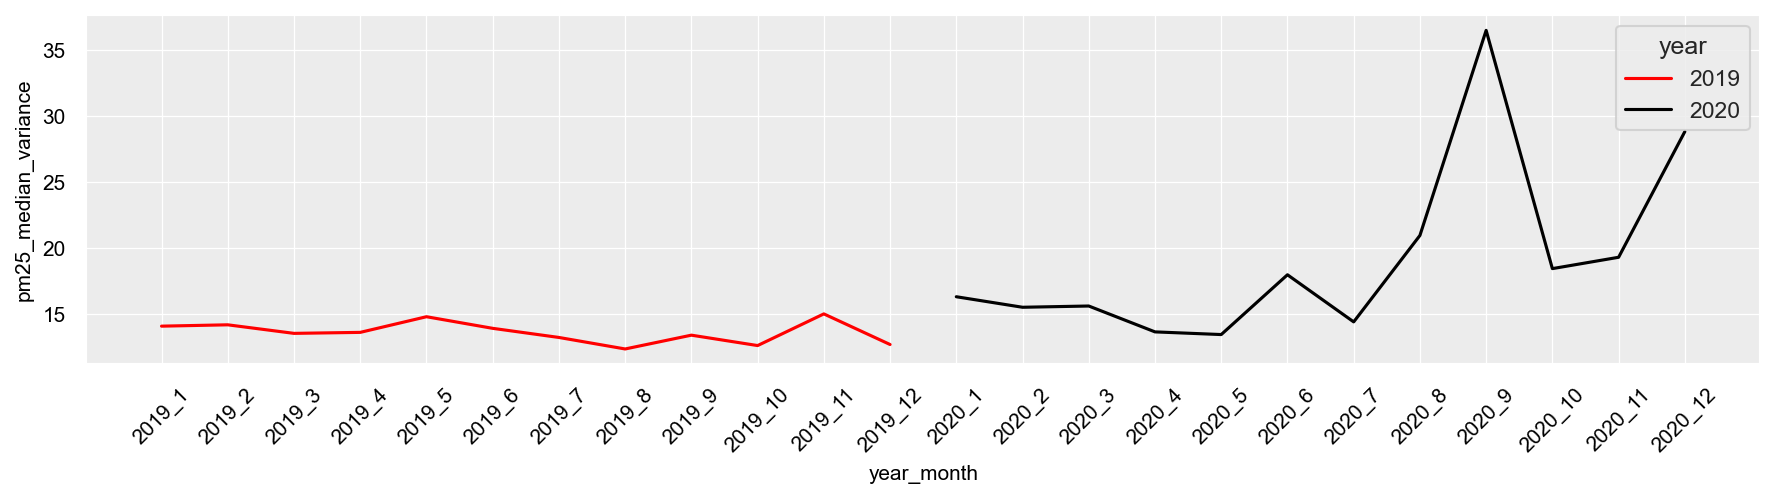

In [9]:
year_month_var = data.groupby(['year', 'month'], as_index=False)['pm25_median'].std()
year_month_var['year_month'] = year_month_var['year'].astype(str) + '_' + year_month_var['month'].astype(str)
year_month_var = year_month_var.rename(columns={'pm25_median': 'pm25_median_variance'})

with plt.rc_context(rc = {'figure.dpi': 150, 'axes.labelsize': 10, 
                          'xtick.labelsize': 10, 'ytick.labelsize': 10}):
    
    fig, axes = plt.subplots(2, 1, figsize = (12, 6))
    ax_flat = axes.flatten()

    sns.lineplot(ax=ax_flat[0], x=year_month_var['year_month'], palette=['#FF0000', '#000000'],
                 y=year_month_var['pm25_median_variance'], hue=year_month_var['year'])
    
    plt.setp(ax_flat[0].get_xticklabels(), rotation=45)
    ax_flat[1].set_visible(False)

plt.tight_layout()
plt.show()

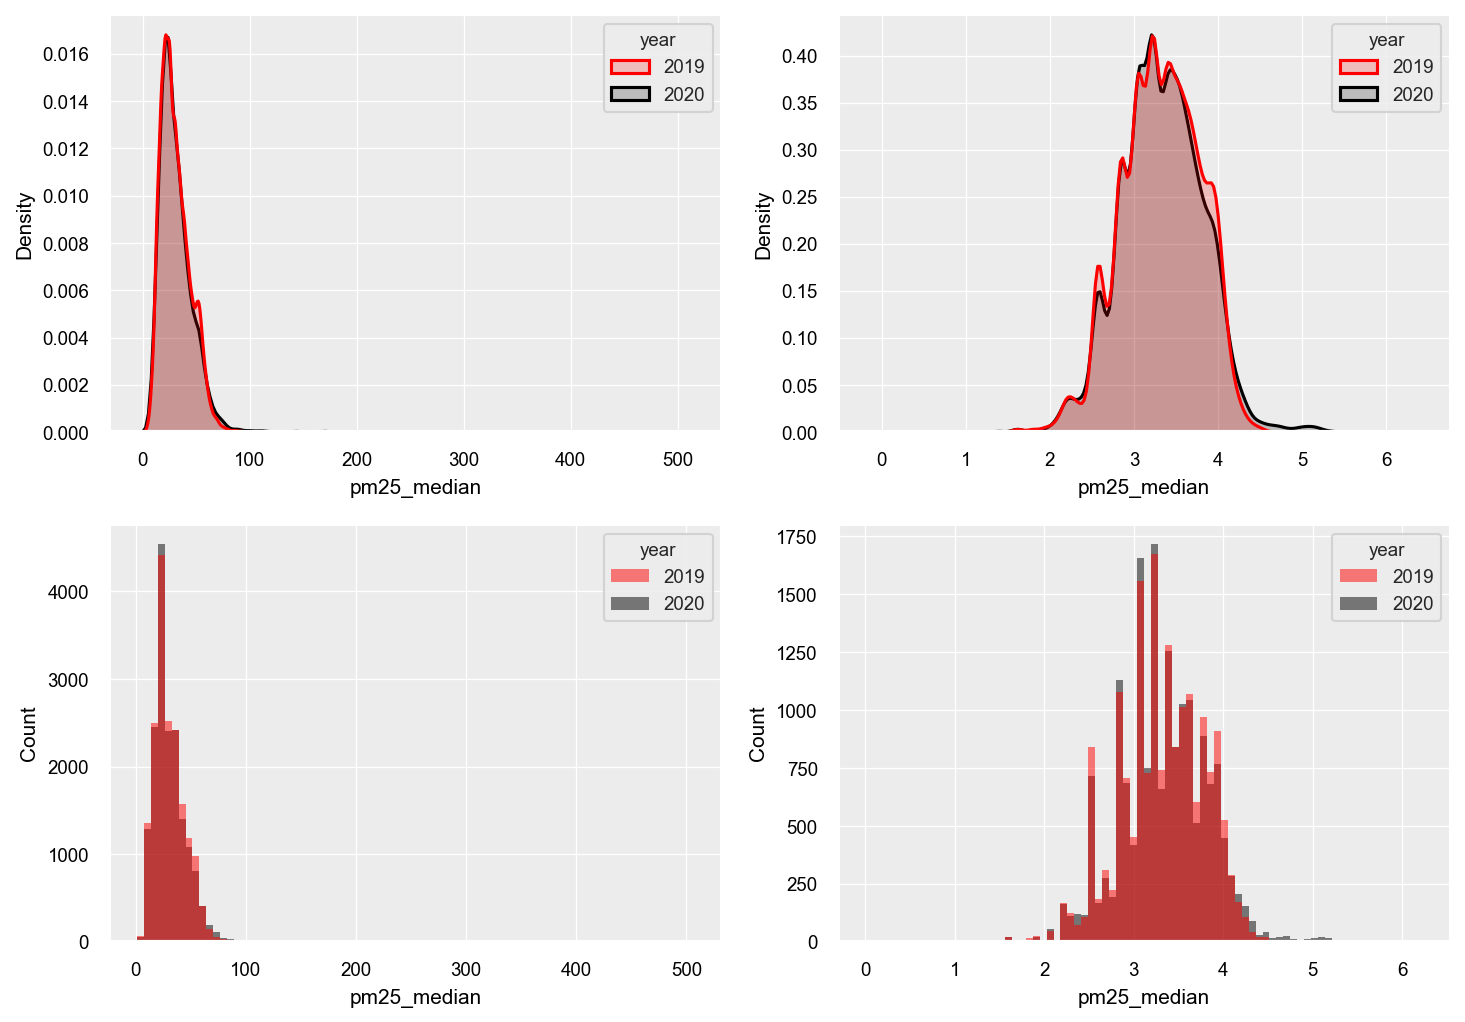

In [10]:
with plt.rc_context(rc = {'figure.dpi': 150, 'axes.labelsize': 10, 
                          'xtick.labelsize': 9, 'ytick.labelsize': 9, 
                          'legend.fontsize': 9, 'legend.title_fontsize': 9}):
    
    fig, axes = plt.subplots(2, 2, figsize = (10, 7))
    ax_flat = axes.flatten()

    sns.kdeplot(ax=ax_flat[0], x=data['pm25_median'], palette=['red', 'black'], hue=data['year'],
                fill=True, alpha=0.2, linewidth=1.5)
    
    sns.kdeplot(ax=ax_flat[1], x=np.log(data['pm25_median']), palette=['red', 'black'], hue=data['year'],
                fill=True, alpha=0.2, linewidth=1.5)
    
    sns.histplot(ax=ax_flat[2], x=data['pm25_median'], palette=['red', 'black'], hue=data['year'],
                 bins=80, linewidth=0)
    
    sns.histplot(ax=ax_flat[3], x=np.log(data['pm25_median']), palette=['red', 'black'], hue=data['year'],
                 bins=80, linewidth=0)

plt.tight_layout()
plt.show()

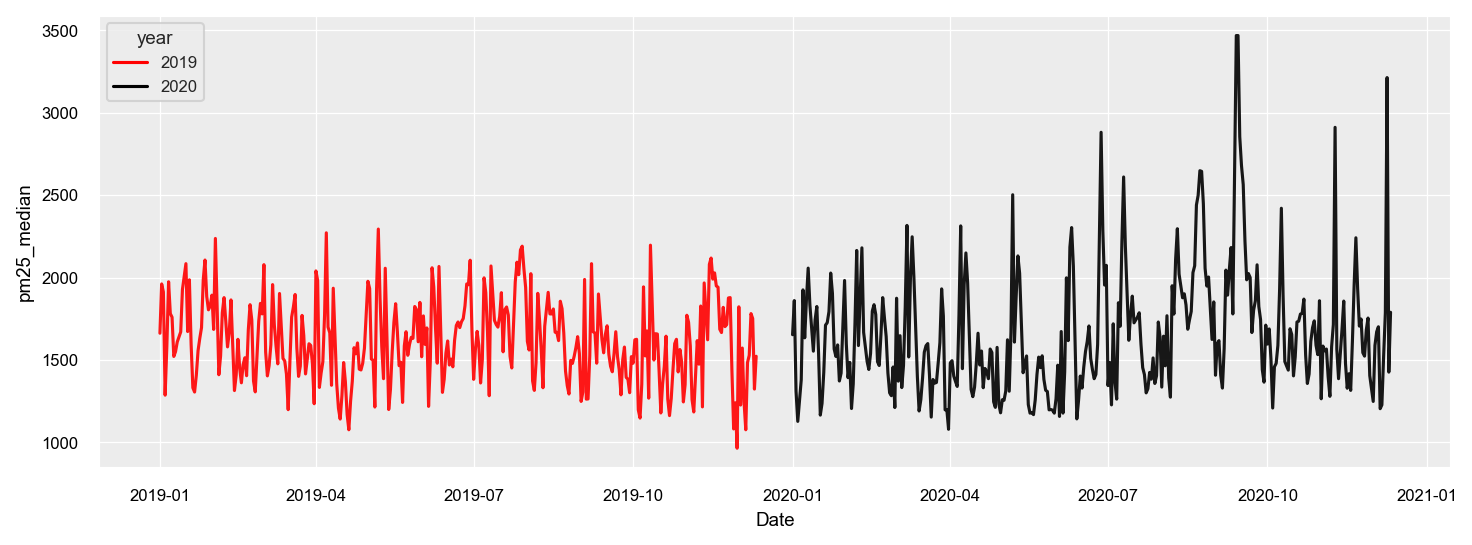

In [11]:
with plt.rc_context(rc = {'figure.dpi': 150, 'axes.labelsize': 9, 
                          'xtick.labelsize': 8, 'ytick.labelsize': 8, 
                          'legend.fontsize': 8, 'legend.title_fontsize': 9}):
    
    fig, axes = plt.subplots(2, 1, figsize = (10, 7))
    ax_flat = axes.flatten()

    data_year = data.groupby(['Date', 'year'], as_index=False)['pm25_median'].sum()

    sns.lineplot(ax=ax_flat[0], x=data_year['Date'], y=data_year['pm25_median'], 
                 palette=['red', 'black'], hue=data_year['year'],
                 alpha=0.9, linewidth=1.5)
    
    ax_flat[1].set_visible(False)

plt.tight_layout()
plt.show()

del data_year

#### 3.2 Monthly variability (temporal)

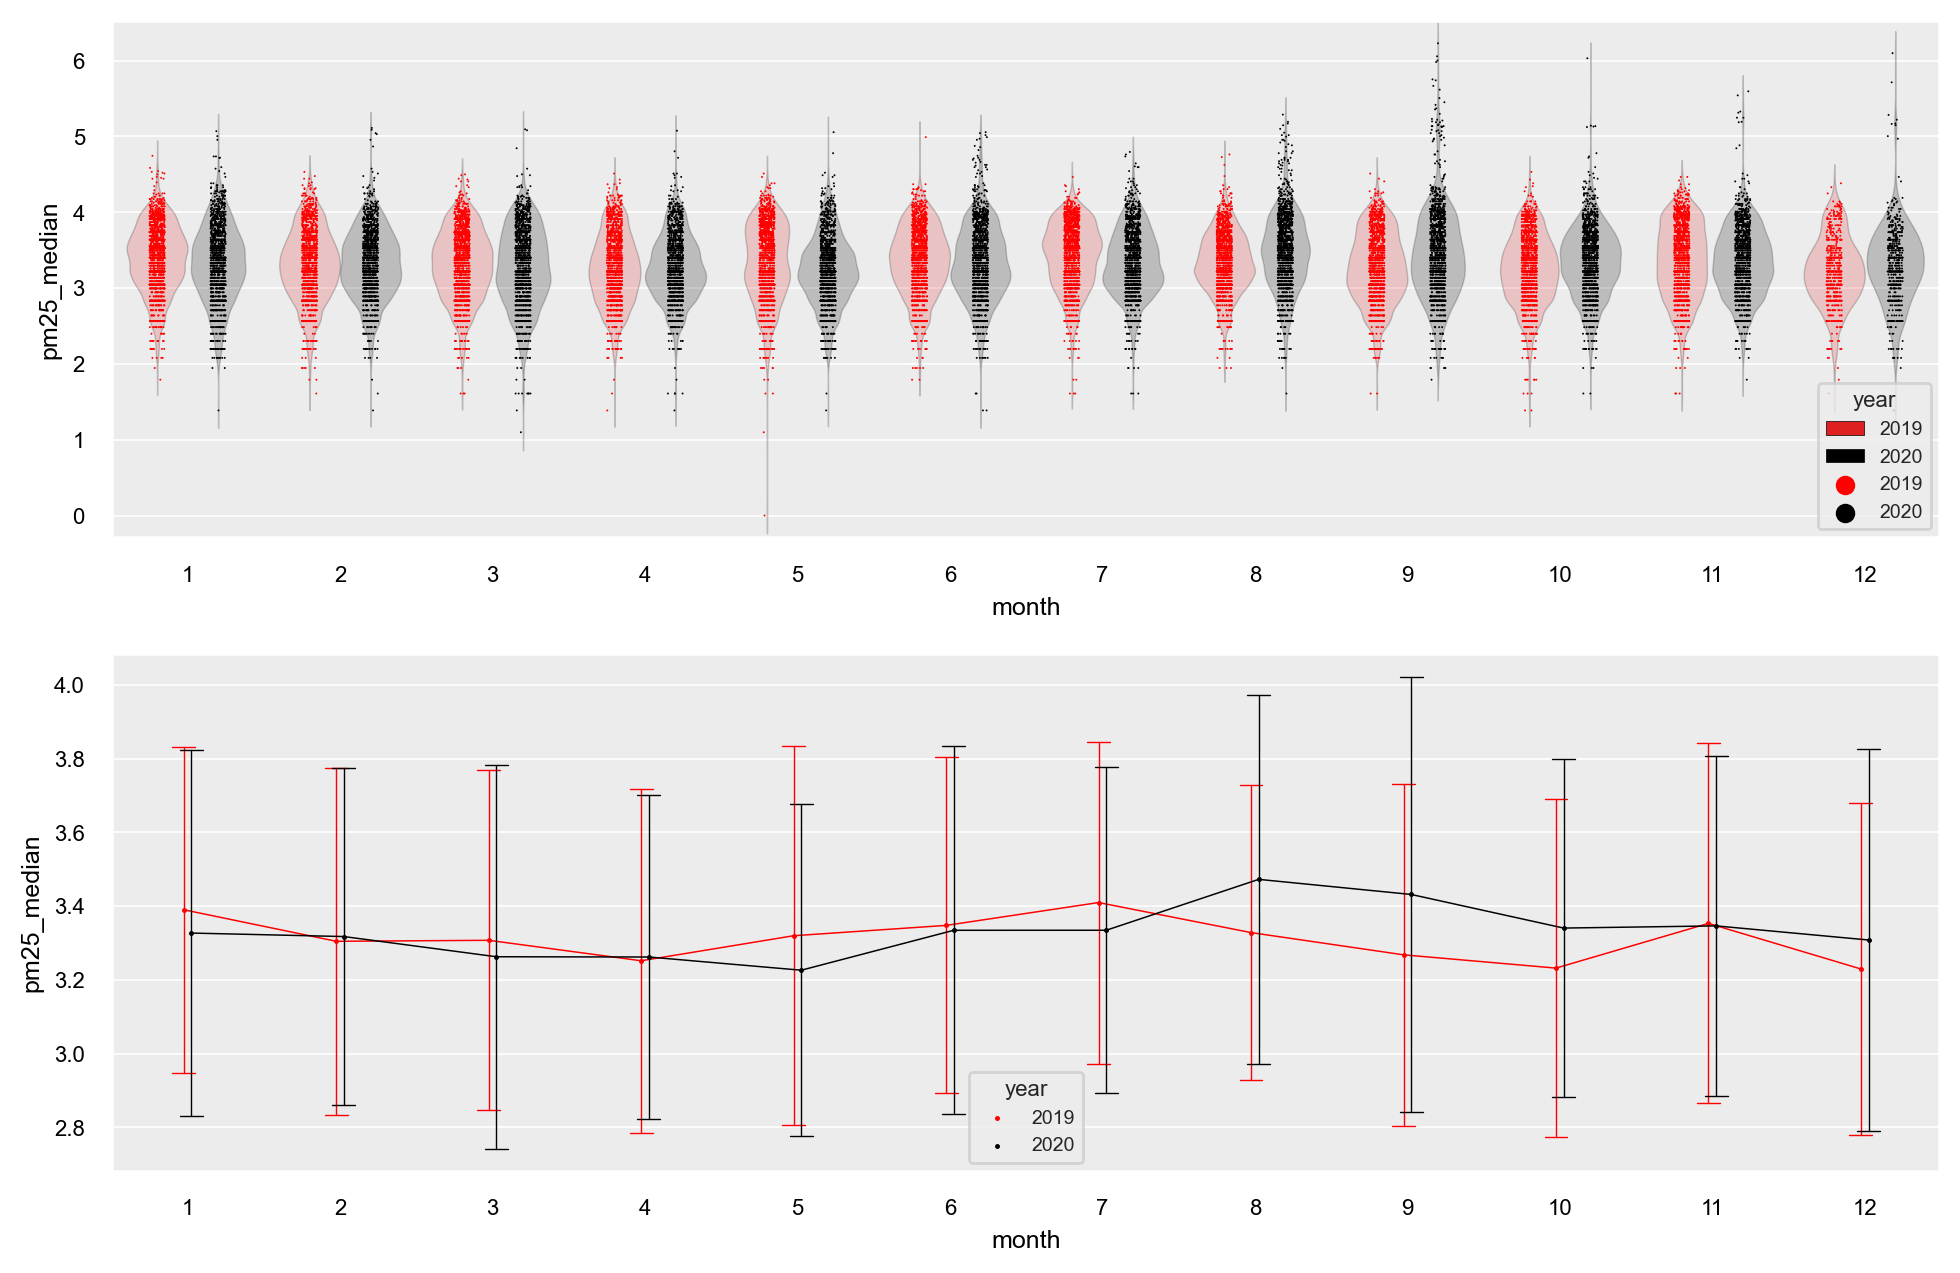

In [12]:
with plt.rc_context(rc={'figure.dpi': 200, 'axes.labelsize': 9, 
                        'xtick.labelsize': 8, 'ytick.labelsize': 8,
                        'legend.fontsize': 7, 'legend.title_fontsize': 8}):

    fig, axes = plt.subplots(2, 1, figsize=(10, 6.5))
    ax_flat = axes.flatten()

    sns.violinplot(ax=ax_flat[0], x=data['month'], y=np.log(data['pm25_median']),
                   palette=['red', 'black'], hue=data['year'], dodge=True, 
                   density_norm='width', linewidth=0.5, inner=None)
    
    plt.setp(ax_flat[0].collections, alpha=0.2)

    sns.stripplot(ax=ax_flat[0], x=data['month'], y=np.log(data['pm25_median']),
                  palette=['red', 'black'], hue=data['year'], dodge=True, s=0.7, alpha=1, jitter=0.1)
    
    sns.pointplot(ax=ax_flat[1], x=data['month'], y=np.log(data['pm25_median']),
                  palette=['red', 'black'], hue=data['year'], dodge=True, 
                  scale=0.2, estimator=np.mean, errorbar='sd', errwidth=0.5, capsize=0.15, join=True)
    
    # ax_flat[1].set_visible(False)

plt.tight_layout(pad=1)
plt.show()

#### 3.3 ACF and PACF plots (spatio-temporal)

In [13]:
random_strings = random.sample(list(data['City'].unique()), 12)
subset = data[data['City'].isin(random_strings)][['City', pollutants_target]]
subset[pollutants_target] = subset[pollutants_target].fillna(np.mean(subset[pollutants_target]))  # Group by City

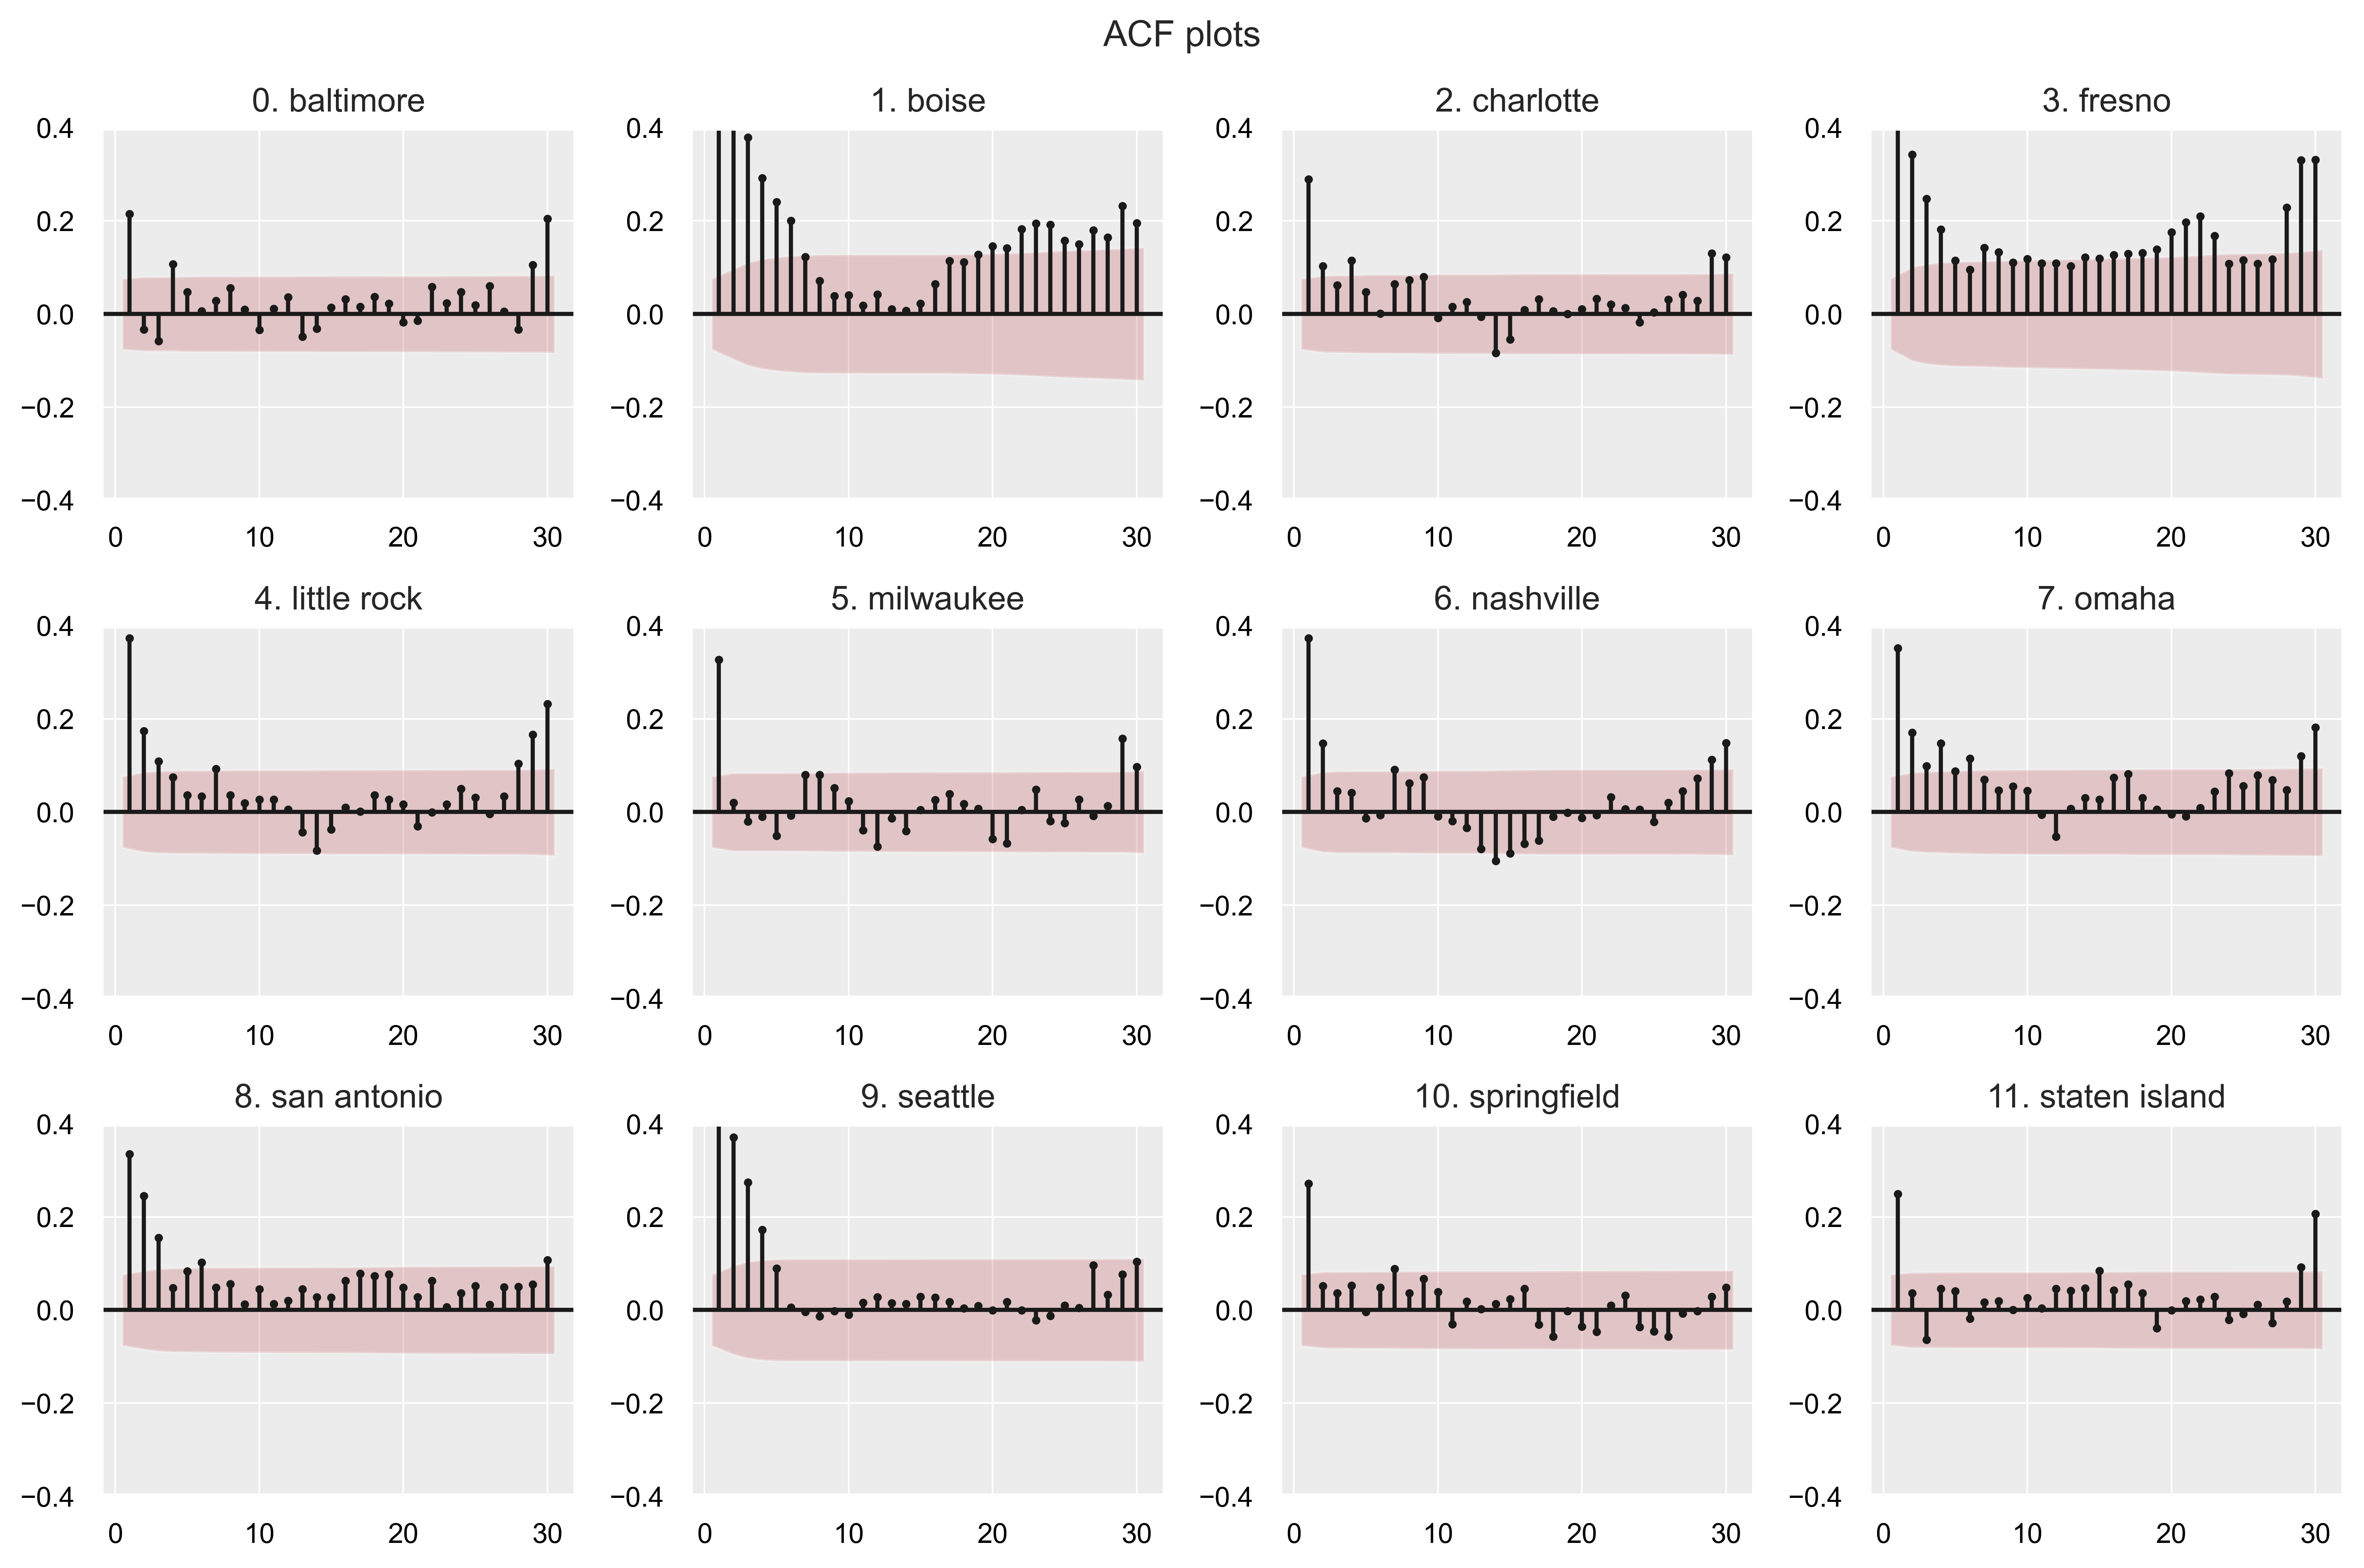

In [14]:
with plt.rc_context(rc={'figure.dpi': 500, 'axes.labelsize': 11, 
                        'xtick.labelsize': 10, 'ytick.labelsize': 10}): 
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    ax_flat = axes.flatten()

    for idx, (city, ax) in enumerate(zip(subset['City'].unique(), ax_flat)):
        tsaplots.plot_acf(subset[subset['City'] == city][pollutants_target].to_numpy(), 
                          lags=30, ax=ax, zero=False,
                          markerfacecolor='k', markeredgecolor='k', markersize=2,
                          vlines_kwargs={"colors": 'k'}, title=f'{idx}. {city}')
        
        ax.collections[1].set_facecolor('r')
        ax.lines[0].set_color('k')
        ax.set_ylim(-0.4, 0.4)
        
    fig.suptitle('ACF plots', fontsize=13)
    plt.tight_layout(pad=1)
    plt.show()

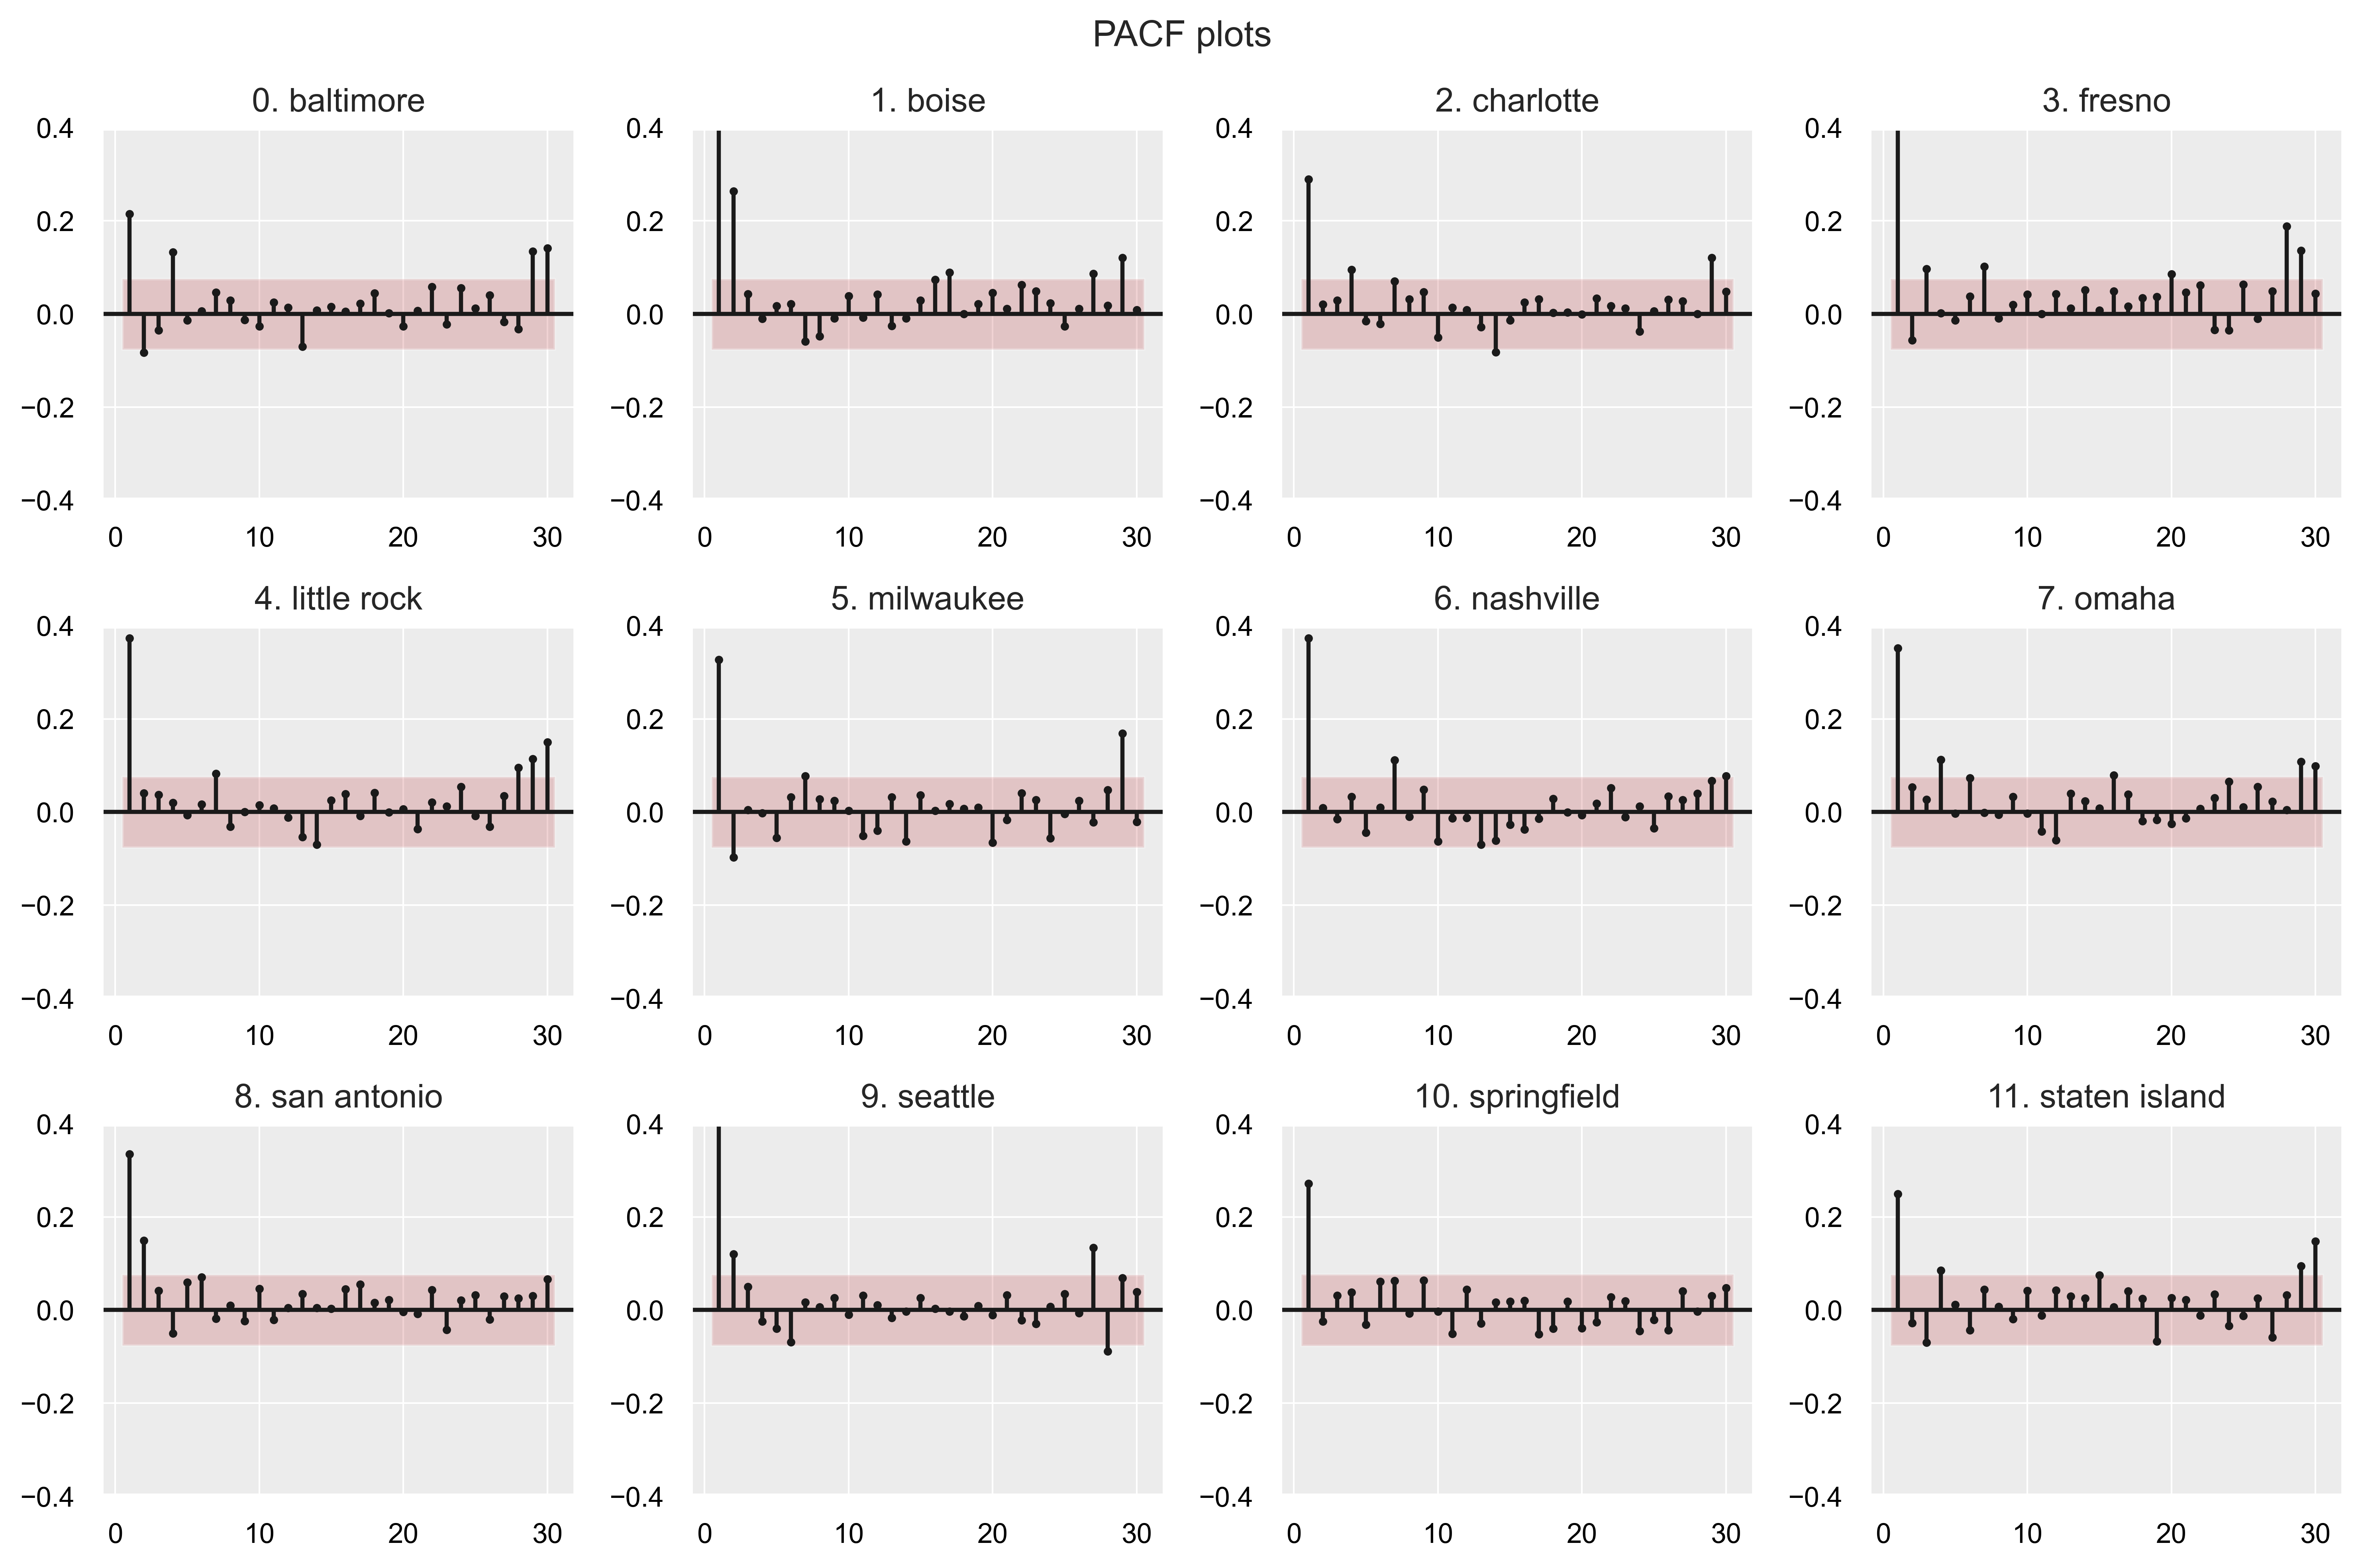

In [15]:
with plt.rc_context(rc={'figure.dpi': 500, 'axes.labelsize': 11, 
                        'xtick.labelsize': 10, 'ytick.labelsize': 10}): 
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    ax_flat = axes.flatten()

    for idx, (city, ax) in enumerate(zip(subset['City'].unique(), ax_flat)):
        tsaplots.plot_pacf(subset[subset['City'] == city][pollutants_target].to_numpy(), 
                           lags=30, ax=ax, zero=False,
                           markerfacecolor='k', markeredgecolor='k', markersize=2,
                           vlines_kwargs={"colors": 'k'}, title=f'{idx}. {city}')
        
        ax.collections[1].set_facecolor('r')
        ax.lines[0].set_color('k')
        ax.set_ylim(-0.4, 0.4)
    
    fig.suptitle('PACF plots', fontsize=13)
    plt.tight_layout(pad=1)
    plt.show()
    
    del subset

#### 3.4 Annual seasonality (spatio-temporal)

In [16]:
data_month_pm25 = data.groupby(['City', 'month', 'year'], as_index=False)[pollutants_target].mean()

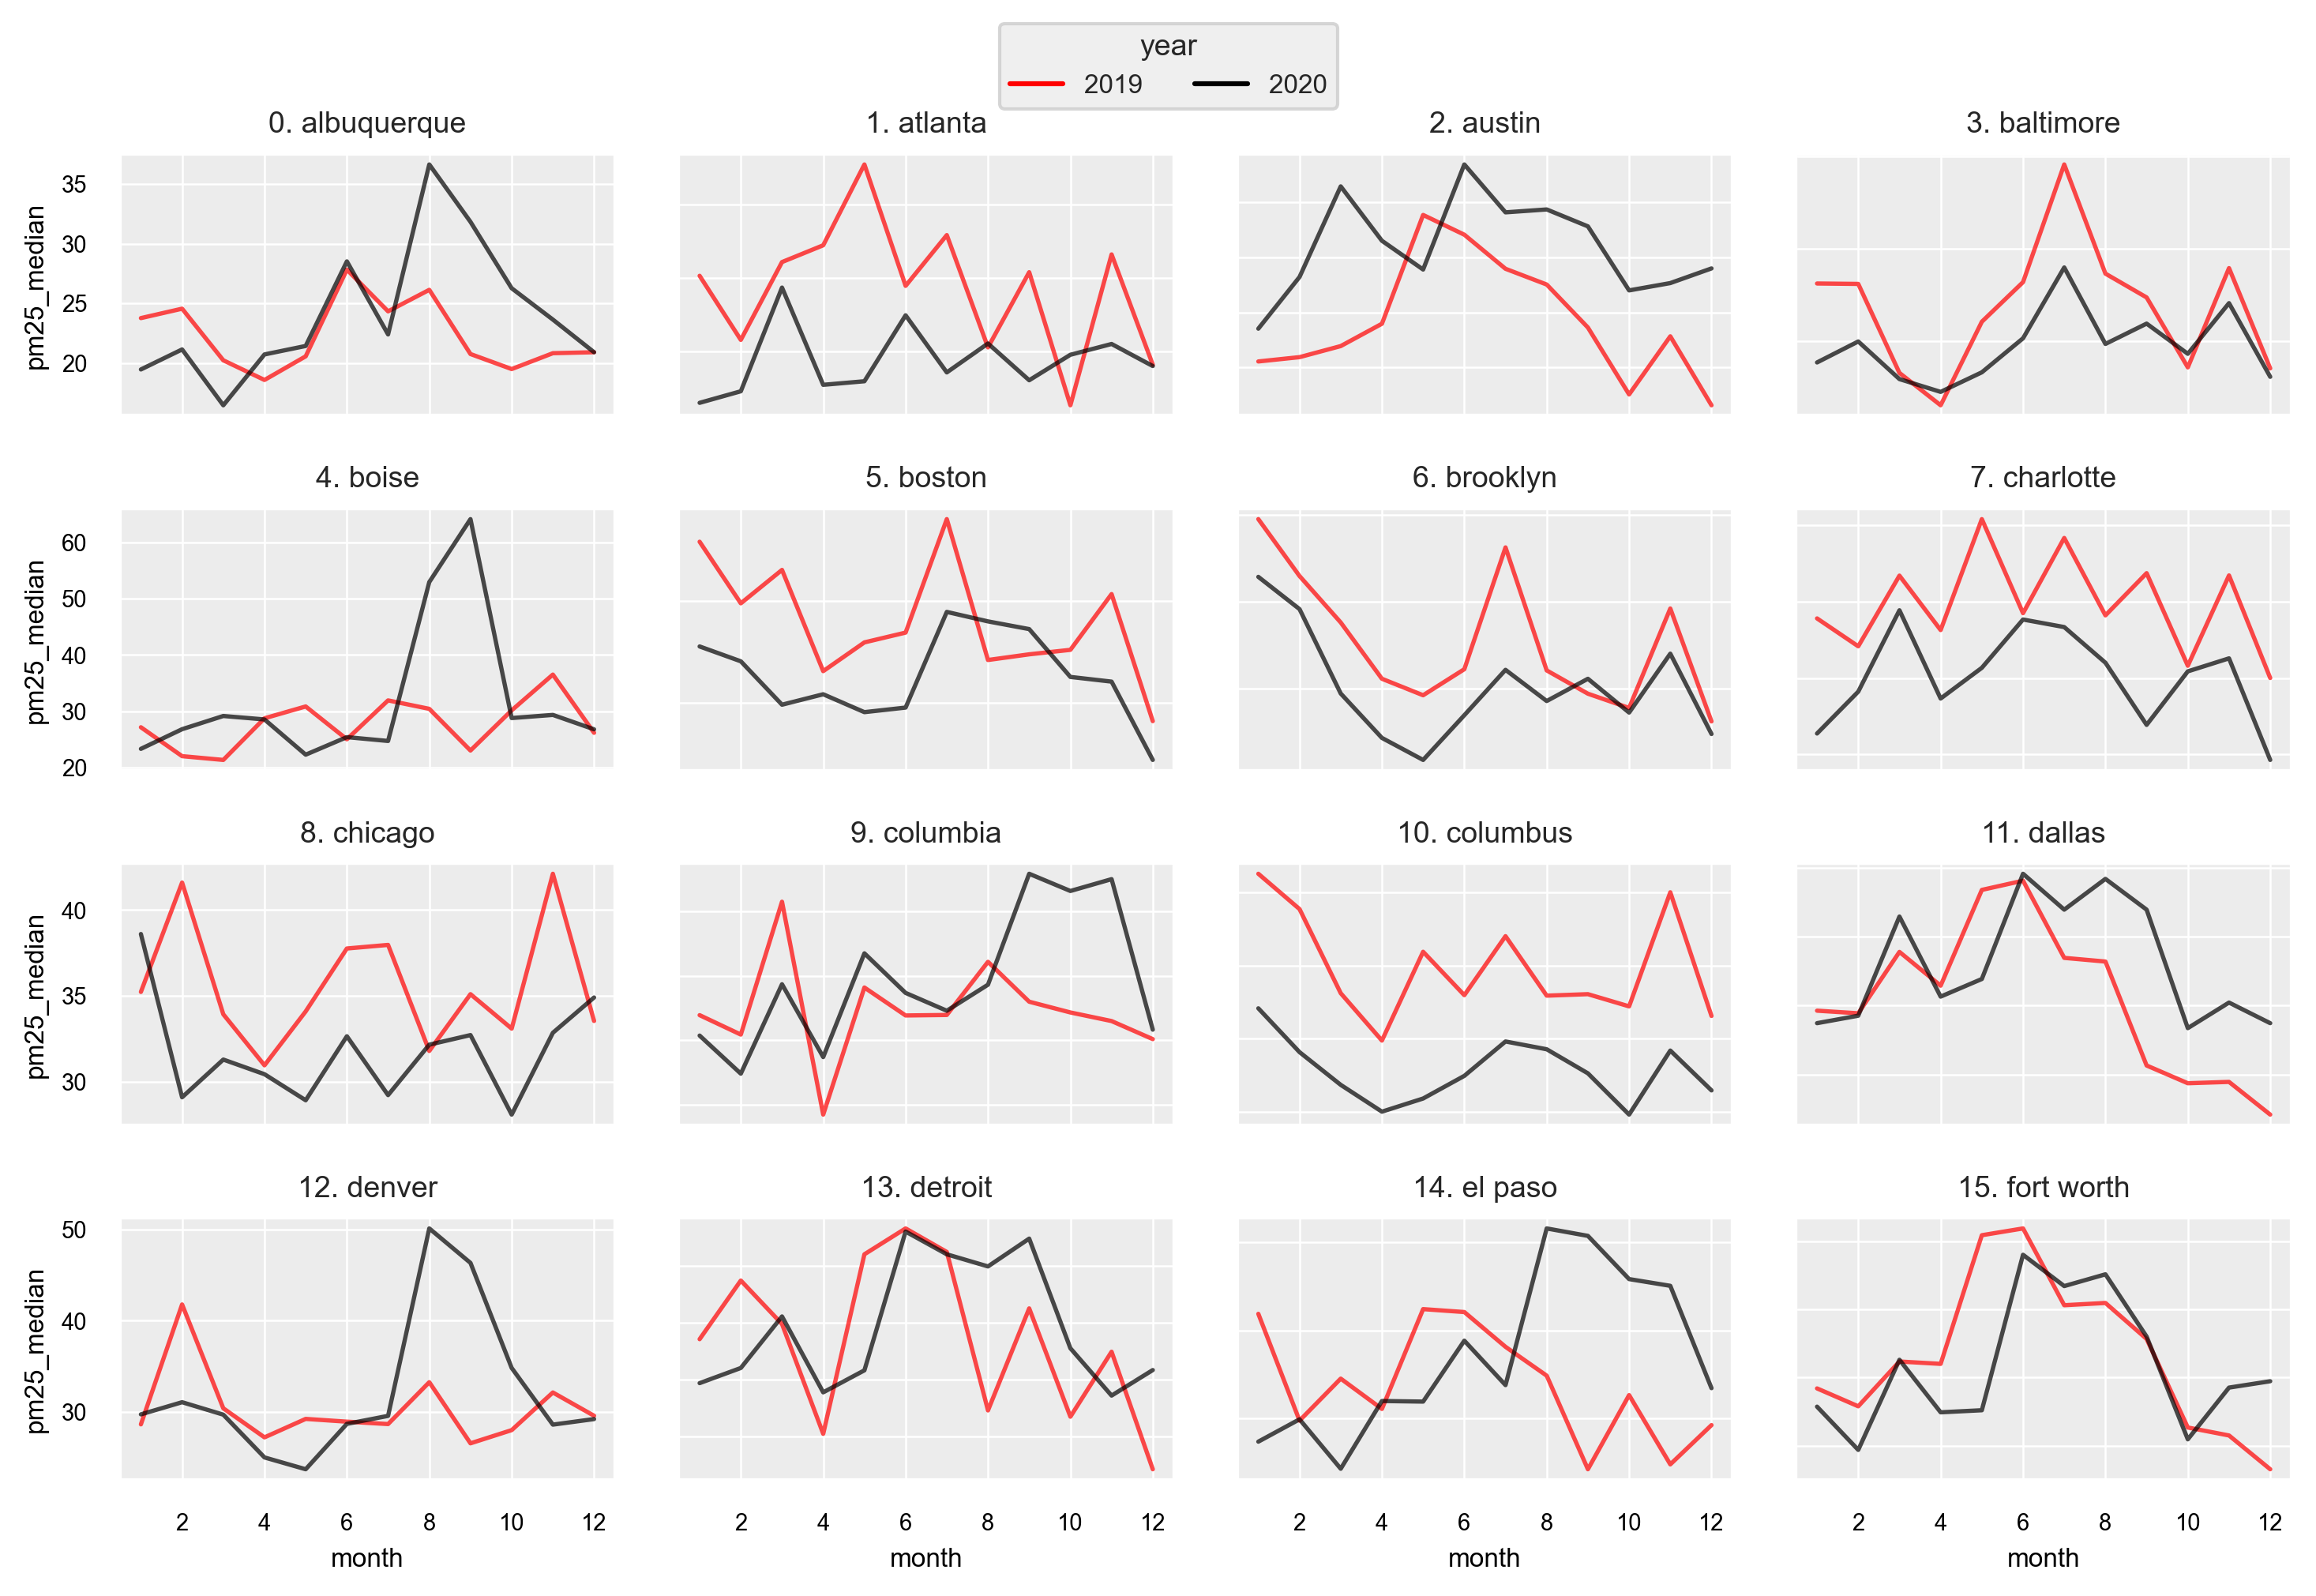

In [17]:
with plt.rc_context(rc={'figure.dpi': 300, 'axes.labelsize': 8, 
                        'xtick.labelsize': 7, 'ytick.labelsize': 7,
                        'legend.fontsize': 7, 'legend.title_fontsize': 8}):

    fig, axes = plt.subplots(int((len(cities_list[0:16]) / 4)), 4, figsize=(10, 6.5))
    ax_flat = axes.flatten()

    for idx, (city, ax) in enumerate(zip(cities_list[0:16], ax_flat)):
        subset_city = data_month_pm25.loc[data_month_pm25['City'] == city]
    
        sns.lineplot(ax=ax, x=subset_city['month'], y=subset_city['pm25_median'], 
                     palette=['red', 'black'], hue=subset_city['year'], lw=1.3, alpha=0.7)
        
        ax.get_legend().remove()
        ax.set_title(f'{idx}. {city}', fontsize=9)
        ax.label_outer()

    # Global legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=2, 
               fontsize=8, title='year', title_fontsize=9)

    plt.tight_layout(pad=1)
    plt.show()

    del subset_city

#### 3.5 Distributions (spatial)

In [18]:
cities_group = [data['City'].unique()[x:x+12] for x in range(0, len(data['City'].unique()), 12)]

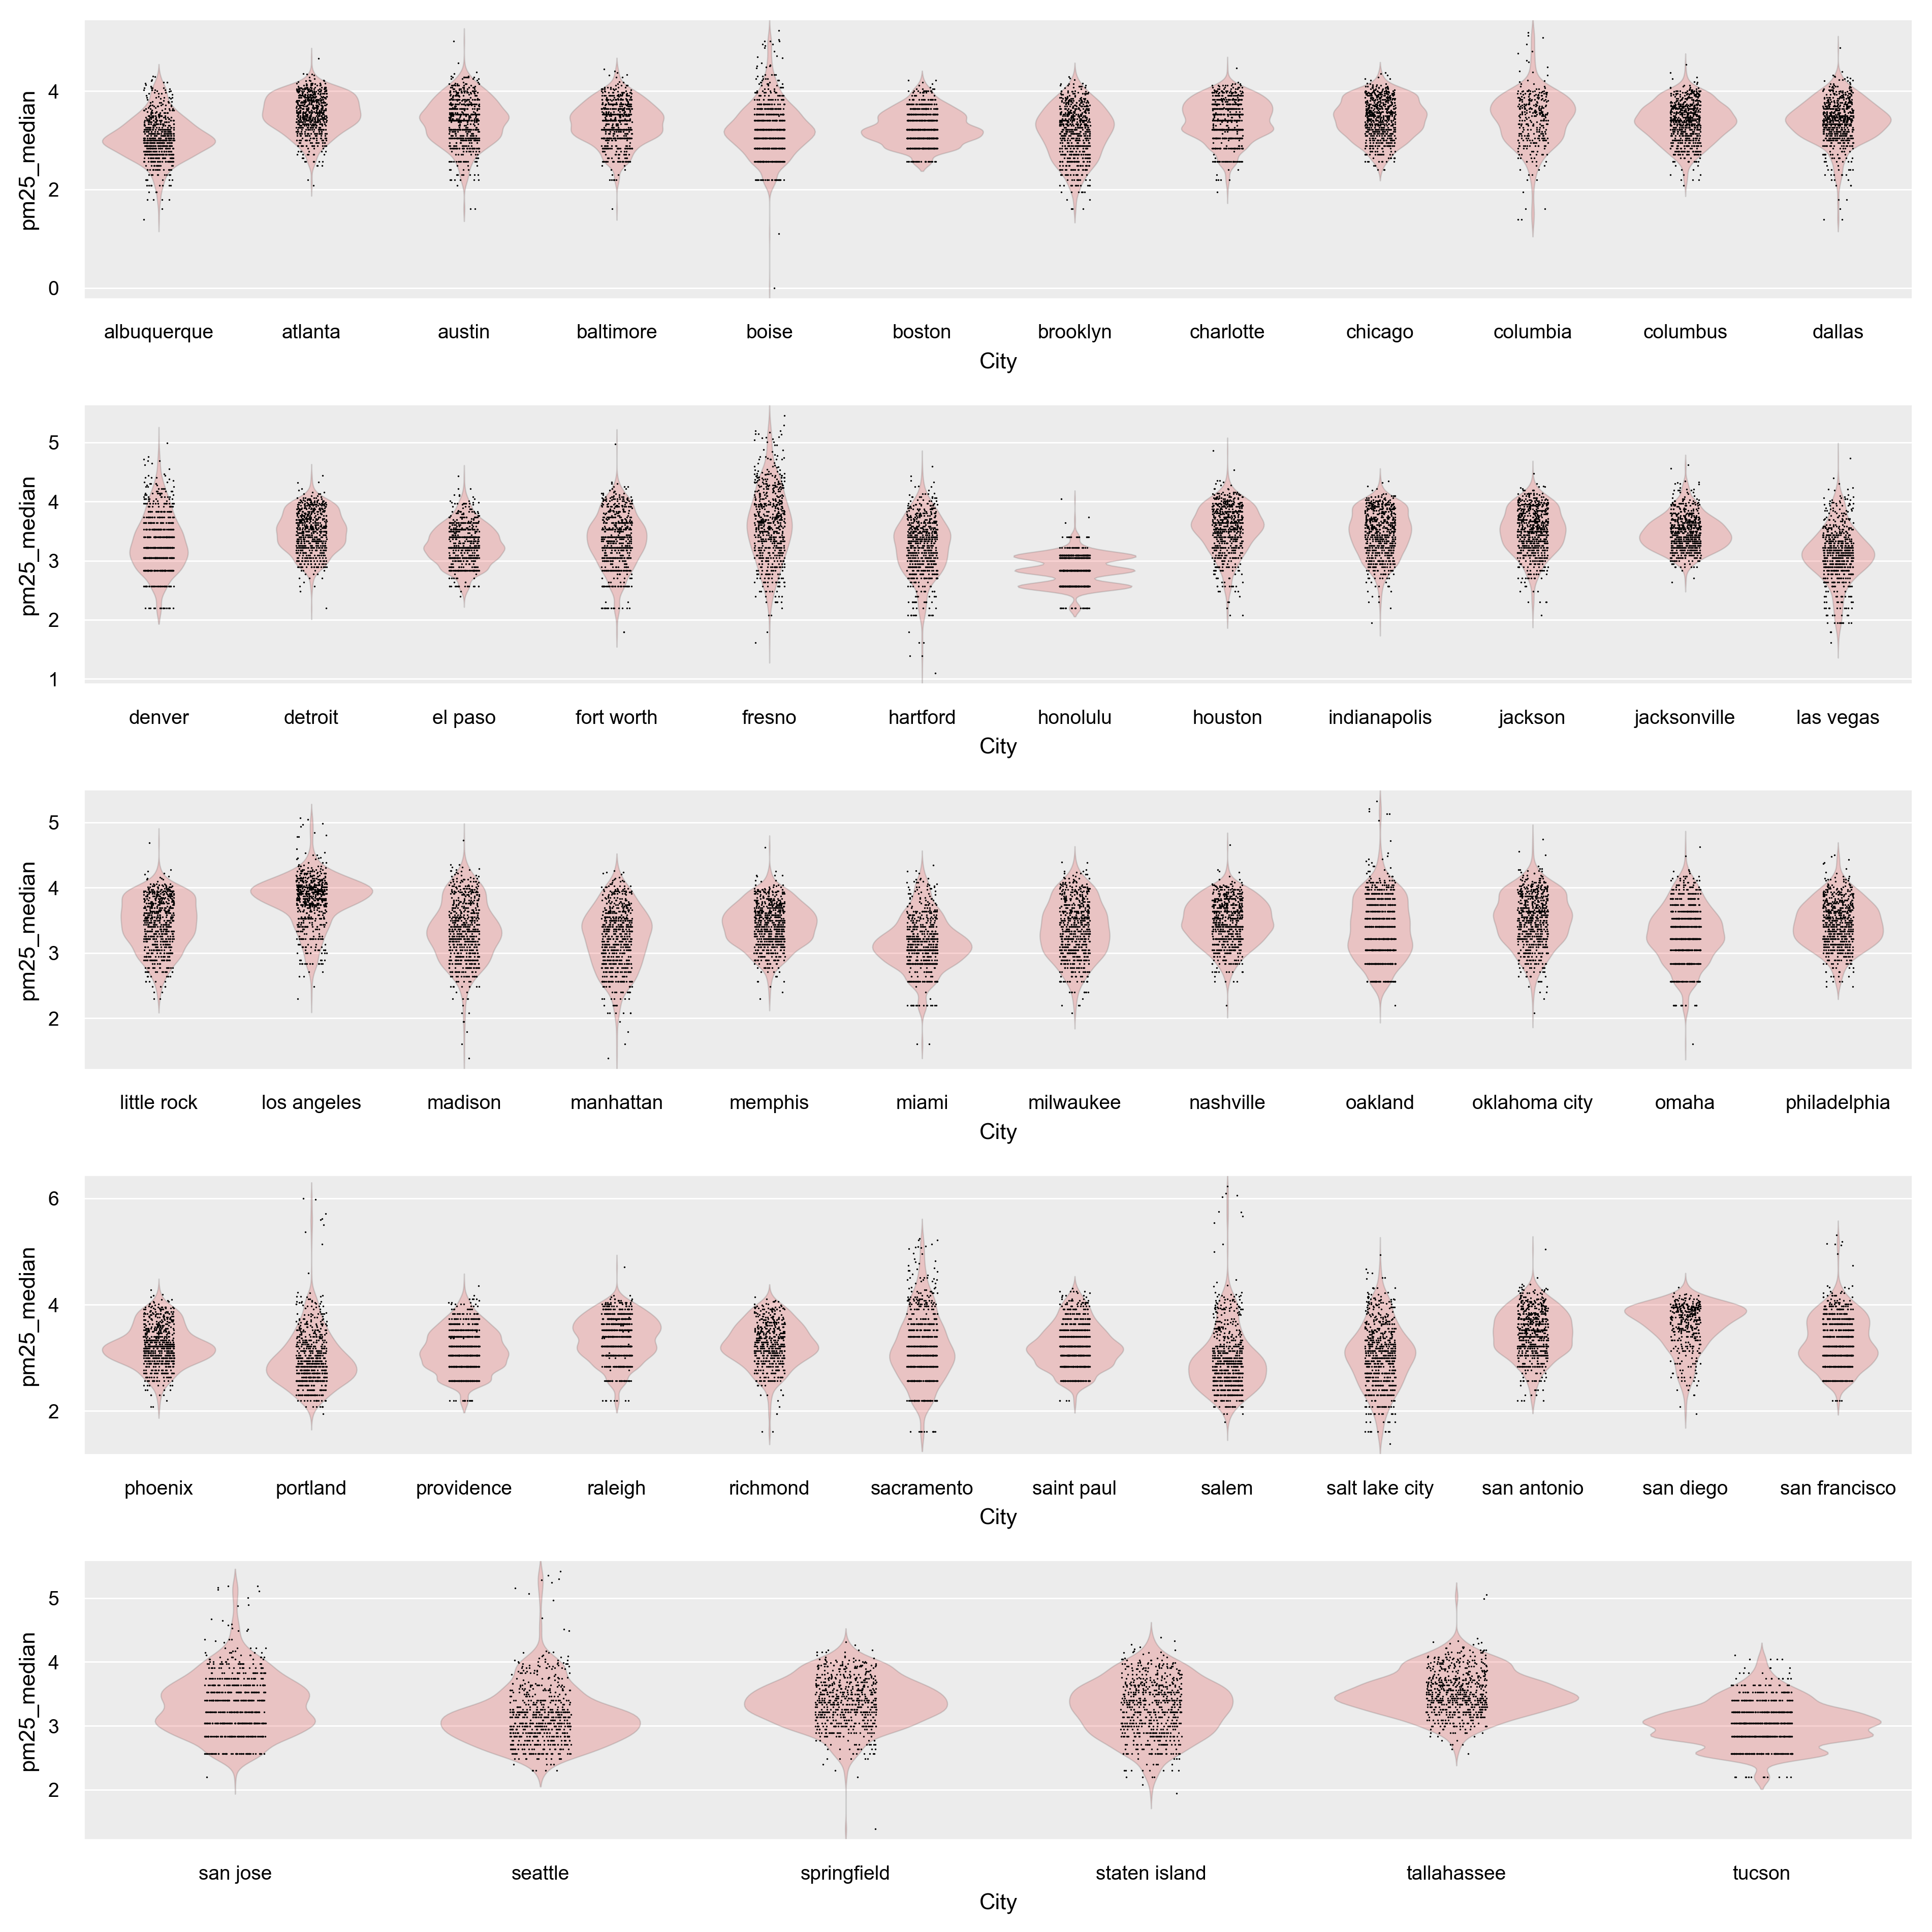

In [19]:
with plt.rc_context(rc={'figure.dpi': 350, 'axes.labelsize': 9, 
                        'xtick.labelsize': 8, 'ytick.labelsize': 8}):

    fig, axes = plt.subplots(len(cities_group), 1, figsize=(11, 11))
    ax_flat = axes.flatten()

    for city_group, ax in zip(cities_group, ax_flat):
        subset_city = data.loc[data['City'].isin(city_group)]

        sns.violinplot(ax=ax, x=subset_city['City'], y=np.log(subset_city['pm25_median']),
                       color='red', density_norm='width', linewidth=0.5, inner=None)
        
        plt.setp(ax.collections, alpha=0.2)

        sns.stripplot(ax=ax, x=subset_city['City'], y=np.log(subset_city['pm25_median']),
                      color='black', s=0.7, alpha=1, jitter=0.1)
        
plt.tight_layout(pad=1)
plt.show()

del subset_city

### 4. EDA: multivariate analysis

In [20]:
subset_cols = list(set(data.select_dtypes(include=[int, float]).columns) - {'pm25_median', 'month', 'year'})

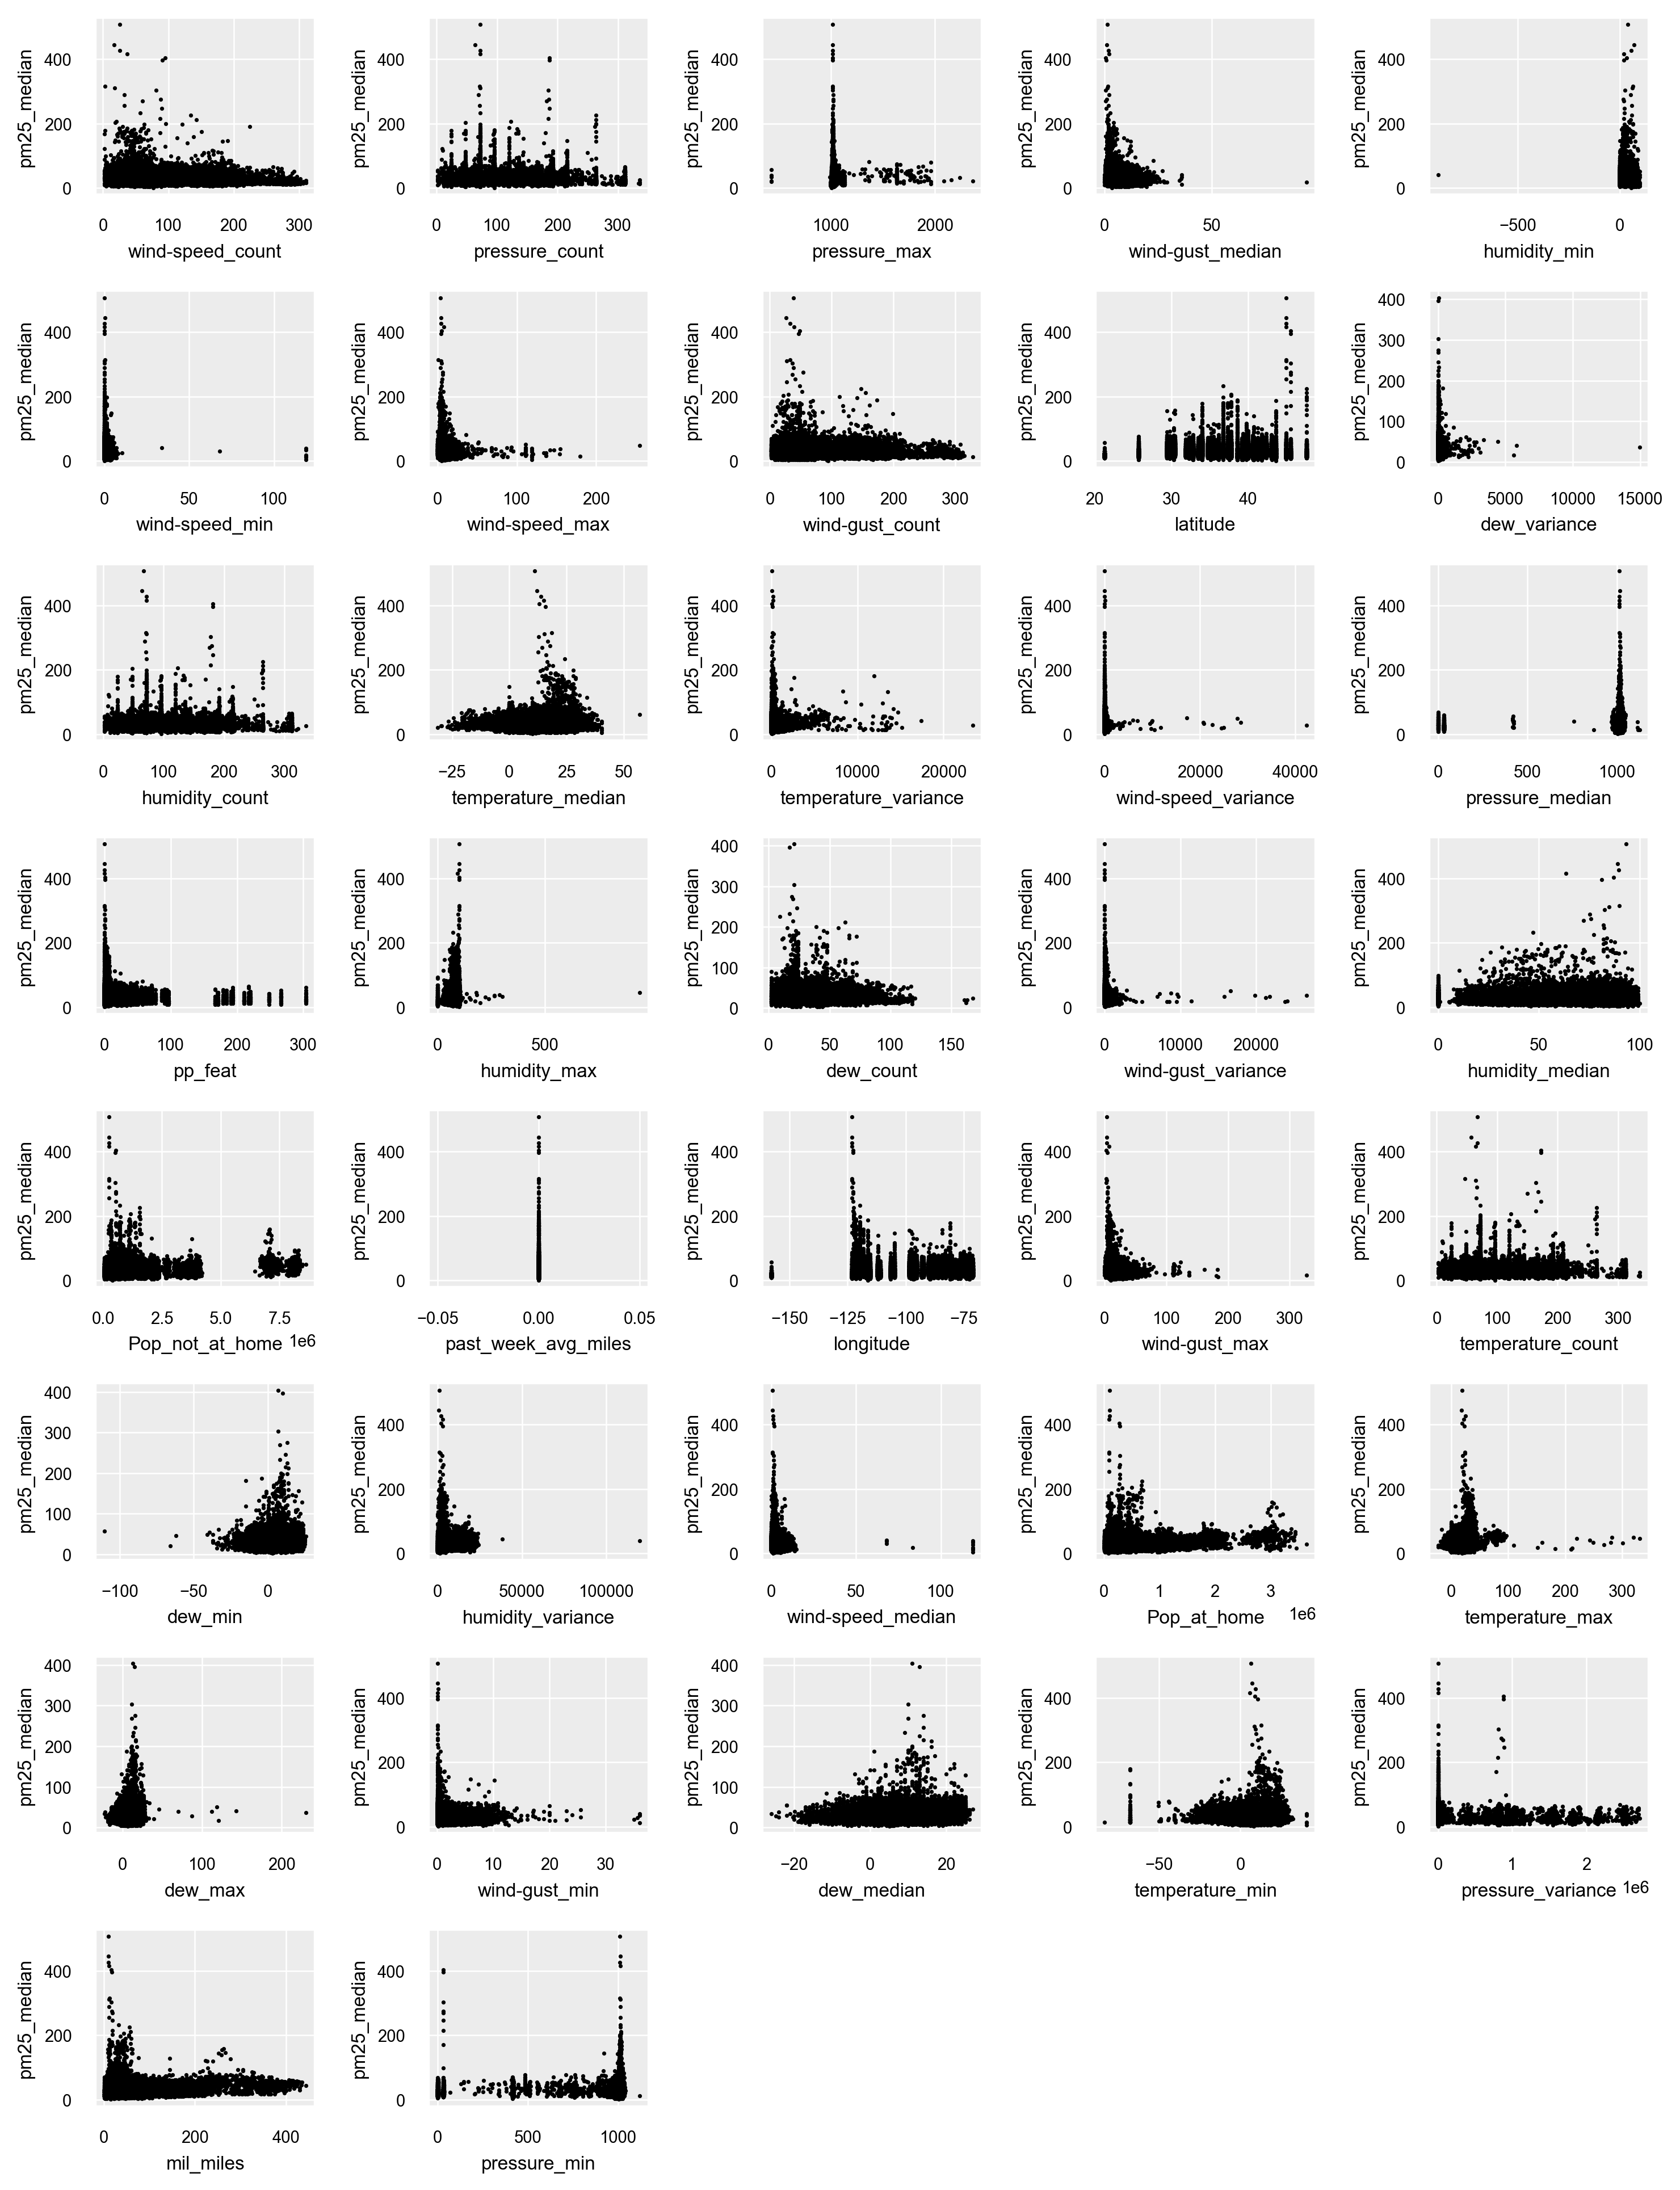

In [21]:
with plt.rc_context(rc={'figure.dpi': 300, 'axes.labelsize': 8, 
                        'xtick.labelsize': 7, 'ytick.labelsize': 7,
                        'legend.fontsize': 7, 'legend.title_fontsize': 8}):

    fig, axes = plt.subplots(8, 5, figsize=(10, 13))
    ax_flat = axes.flatten()

    for idx, (col, ax) in enumerate(zip(subset_cols, ax_flat)):
        sns.scatterplot(ax=ax, x=data[col], y=data['pm25_median'], color='black',
                        linewidth=0, alpha=1, s=3)

    # Removing empty figures
    [axes.set_visible(False) for axes in ax_flat[idx + 1:]]

    plt.tight_layout(pad=1)
    plt.show()

In [22]:
# Dropping a variable with a constant value
data = data.drop('past_week_avg_miles', axis=1)

In [23]:
corr_pearson = data.select_dtypes(include=[int, float]).corrwith(data['pm25_median'], method='pearson')
corr_spearman = data.select_dtypes(include=[int, float]).corrwith(data['pm25_median'], method='spearman')

data_no_nan = data.dropna()
mi_scores = {}

for col in data.select_dtypes(include=[int, float]).columns:
    mi_scores[col] = mutual_info_regression(data_no_nan[[col]], data_no_nan['pm25_median'])[0]

del data_no_nan

data_correlations = pd.DataFrame({'Pearson_correlation': corr_pearson, 
                                  'Spearman_correlation': corr_spearman,
                                  'Mutual_Information': mi_scores})

data_correlations = data_correlations.drop('pm25_median').sort_values(by='Mutual_Information', ascending=False)

data_correlations

Pearson_correlation  Spearman_correlation  \
latitude                        -0.030405             -0.099663   
longitude                        0.042030              0.105171   
pp_feat                         -0.033456              0.073992   
Pop_not_at_home                  0.117333              0.060585   
Pop_at_home                      0.118316              0.045806   
temperature_max                  0.146501              0.226613   
mil_miles                        0.115703              0.076190   
wind-speed_median               -0.075226             -0.129596   
temperature_min                  0.072791              0.133654   
temperature_median               0.120458              0.186492   
dew_median                       0.148082              0.209526   
temperature_count               -0.071497             -0.074932   
wind-speed_count                -0.127617             -0.136669   
dew_max                          0.126666              0.195804   
wind-gust_median                -0.190814             -0.230673   
pressure_count                  -0.071468             -0.074495   
wind-gust_count                 -0.130878             -0.140055   
humidity_count                  -0.070990             -0.074352   
humidity_max                     0.079682              0.083451   
wind-speed_max                  -0.098483             -0.147937   
dew_min                          0.132727              0.187114   
humidity_min                     0.016488              0.041331   
wind-gust_max                   -0.159867             -0.207349   
humidity_median                  0.065208              0.081418   
temperature_variance             0.078089              0.189563   
pressure_variance               -0.057541             -0.127894   
wind-gust_min                   -0.043247             -0.085112   
wind-speed_variance             -0.013096             -0.137726   
wind-speed_min                  -0.009940             -0.021206   
dew_count                       -0.028868             -0.016174   
humidity_variance                0.041100              0.094377   
wind-gust_variance              -0.055372             -0.184215   
pressure_min                     0.063603              0.073401   
dew_variance                    -0.016687             -0.037244   
pressure_max                     0.006209             -0.056047   
month                            0.025283              0.010912   
pressure_median                  0.027897              0.000069   
year                             0.036112              0.003567   

                      Mutual_Information  
latitude                        0.310605  
longitude                       0.308127  
pp_feat                         0.202182  
Pop_not_at_home                 0.163036  
Pop_at_home                     0.111754  
temperature_max                 0.108506  
mil_miles                       0.107670  
wind-speed_median               0.095292  
temperature_min                 0.092148  
temperature_median              0.085327  
dew_median                      0.079503  
temperature_count               0.079331  
wind-speed_count                0.078446  
dew_max                         0.077752  
wind-gust_median                0.077449  
pressure_count                  0.077371  
wind-gust_count                 0.074806  
humidity_count                  0.073633  
humidity_max                    0.071127  
wind-speed_max                  0.069346  
dew_min                         0.063785  
humidity_min                    0.062610  
wind-gust_max                   0.061167  
humidity_median                 0.058785  
temperature_variance            0.054273  
pressure_variance               0.054200  
wind-gust_min                   0.049956  
wind-speed_variance             0.046554  
wind-speed_min                  0.045503  
dew_count                       0.042313  
humidity_variance               0.041136  
wind-gust_variance              

## II. Data preparation: addressing data quality issues

### 1. Variables with a large proportion of NaN values (> 5%)

In [24]:
# Imputing missing values taking into account other variables
data_cities = data[data['City'].isin(nulls_group_perc_high_nan['City'].unique())].reset_index(drop=True)
data = data[~data['City'].isin(nulls_group_perc_high_nan['City'].unique())].reset_index(drop=True)

data_city_cols = list(set(data_cities.select_dtypes(include=['number']).columns) - set('pm25_median'))
data_cities_ = data_cities[data_city_cols]

imp = IterativeImputer(max_iter=500, random_state=0, 
                       min_value=data_cities_.describe().iloc[3, :].to_numpy(),
                       max_value=data_cities_.describe().iloc[-1, :].to_numpy() + 0.0001)

data_cities_ = imp.fit_transform(data_cities_)
data_cities_ = pd.DataFrame(data_cities_, columns=data_city_cols)
data_cities_ = pd.concat([data_cities[list(set(data.columns) - set(data_city_cols))], data_cities_], axis=1)

data = pd.concat([data, data_cities_], axis=0)

# Dropping the city with over 40% of missing values
data = data[data['City'] != 'columbia'].reset_index(drop=True)

# Dropping variables with over 40% of missing values
data = data.drop([x for x in data.columns if 'dew' in x], axis=1)

### 2. Variables with a moderate proportion of NaN values (< 5%)

In [25]:
nulls = data.isnull().sum()
nulls = nulls[nulls > 0].index

for i in nulls:
    data[i] = pd.to_numeric(data.groupby('City')[i].transform(lambda x: x.fillna(x.mean())), 
                            downcast='float')

## III. Saving preprocessed data

In [26]:
data = data[~data['City'].isin(['san diego'])]
data = data.drop(['year', 'month'], axis=1)
data = data_utils.squeeze_df(df=data)

with open(f'{path_project}\\data\\city_pollution_data.parquet', 'wb') as handle:
    pq.write_table(pa.Table.from_pandas(data), handle, compression='GZIP')

# Model Development

In [27]:
## Initial parameters

# Paths
path_project = str(Path('__file__').absolute().parent)
path_model = f'{path_project}\\model'

# Config
with open(f'{path_project}\\config.json', 'r') as config_file:
    config = json.load(config_file)

config_data = config['dataset']
config_split = config['train_test_split']

## Data

# Loading data
data = data_utils.get_data(db_url='mysql+mysqlconnector:...',
                           data_path=f'{path_project}\\data\\city_pollution_data.parquet',
                           sql_access=False, date_col=config_data['date_col'], id_col=config_data['id_col'])
print(data.shape)

Using `train_val_test_split()` function from `tuning_cv.py`, the following actions are performed:

- The `train_val_test_split()` function subsets a pandas DataFrame with daily time series data into training, validation, and test sets.
- It organizes the DataFrame by date and, optionally, by an ID column, then partitions the data based on specified test and validation sizes, or supplied test dates if specified.
- Depending on the parameters, it returns separate DataFrames for training, validation, and test sets.

In [30]:
# Splitting data
data_train, _, data_test = tuning_cv.train_val_test_split(df=data, date_col=config_data['date_col'], 
                                                          id_col=config_data['id_col'],
                                                          test_size=config_split['test_size'], val_size_es=None)

# Columns to encode 
target_enc_cols, one_hot_cols = ['City'], ['holiday']

# Columns to ignore (These are identifier which are not required)
ignore_cols = ['County', 'State']

# Model types (Selecting the models to be used for training purpose)
model_types = ['xgb', 'lgb', 'rf', 'lasso']

print("Train size:", data_train.shape)
print("Test size:", data_test.shape)

Train size: (31765, 36)
Test size: (2897, 36)


In [33]:
## Training

# Default models (initializing the TrainPredict() class)
tr_te = training_testing.TrainPredict(df_train=data_train, df_test=data_test, ignore_cols=ignore_cols,
                                      config=config, path=path_model,
                                      date_col=config_data['date_col'], id_col=config_data['id_col'], 
                                      target_col=config_data['target_col'],
                                      exogenous_cols=['wind-gust_median', 'temperature_max'],
                                      model_params_default=True)

# Training different models ('xgb', 'lgb', 'rf', 'lasso')
# This involves creating lag variables and data transformation
for model_type in model_types:
    _ = tr_te.model_training(model_type=model_type, target_enc_cols=target_enc_cols, one_hot_cols=one_hot_cols)

* When concatenating DataFrame with lag variables, make sure that DataFrame is sorted by "City" and "Date" and that the index is reset.
* When concatenating DataFrame with lag variables, make sure that DataFrame is sorted by "City" and "Date" and that the index is reset.
* When concatenating DataFrame with lag variables, make sure that DataFrame is sorted by "City" and "Date" and that the index is reset.
* When concatenating DataFrame with lag variables, make sure that DataFrame is sorted by "City" and "Date" and that the index is reset.
* When concatenating DataFrame with lag variables, make sure that DataFrame is sorted by "City" and "Date" and that the index is reset.
* When concatenating DataFrame with lag variables, make sure that DataFrame is sorted by "City" and "Date" and that the index is reset.
* When concatenating DataFrame with lag variables, make sure that DataFrame is sorted by "City" and "Date" and that the index is reset.
* When concatenating DataFrame with lag variable

In [34]:
# Tuned models (initializing the TrainPredict() class)
tr_te = training_testing.TrainPredict(df_train=data_train, df_test=data_test, ignore_cols=ignore_cols,
                                      config=config, path=path_model,
                                      date_col=config_data['date_col'], id_col=config_data['id_col'], 
                                      target_col=config_data['target_col'],
                                      exogenous_cols=['wind-gust_median', 'temperature_max'],
                                      model_params_default=False)

# Training different models ('xgb', 'lgb', 'rf', 'lasso')
# This involves creating lag variables and data transformation
for model_type in model_types:
    _ = tr_te.model_training(model_type=model_type, target_enc_cols=target_enc_cols, one_hot_cols=one_hot_cols)

* When concatenating DataFrame with lag variables, make sure that DataFrame is sorted by "City" and "Date" and that the index is reset.
* When concatenating DataFrame with lag variables, make sure that DataFrame is sorted by "City" and "Date" and that the index is reset.
* When concatenating DataFrame with lag variables, make sure that DataFrame is sorted by "City" and "Date" and that the index is reset.
* When concatenating DataFrame with lag variables, make sure that DataFrame is sorted by "City" and "Date" and that the index is reset.
* When concatenating DataFrame with lag variables, make sure that DataFrame is sorted by "City" and "Date" and that the index is reset.
* When concatenating DataFrame with lag variables, make sure that DataFrame is sorted by "City" and "Date" and that the index is reset.
* When concatenating DataFrame with lag variables, make sure that DataFrame is sorted by "City" and "Date" and that the index is reset.
* When concatenating DataFrame with lag variable

In [35]:
## Testing and predicting results using the earlier trained models

fc_dates = data_test[config_data['date_col']].unique()
fc_dates_versions = [fc_dates[x:x+7] for x in range(0, len(fc_dates), 7)]

# Models with default hyperparameters
fc_versions = []

for idx, version in enumerate(fc_dates_versions):
    data_train, _, data_test = tuning_cv.train_val_test_split(df=data, date_col=config_data['date_col'], 
                                                              id_col=config_data['id_col'],
                                                              test_size=None, val_size_es=None,
                                                              supply_test_dates=True, test_dates=version)

    tr_te = training_testing.TrainPredict(df_train=data_train, df_test=data_test, ignore_cols=ignore_cols,
                                          config=config, path=path_model,
                                          date_col=config_data['date_col'], id_col=config_data['id_col'], 
                                          target_col=config_data['target_col'],
                                          exogenous_cols=['wind-gust_median', 'temperature_max'],
                                          model_params_default=True)

    fc = tr_te.recursive_forecasting_multiple_models(model_type_list=model_types)
    fc['fc_version'] = idx
    fc_versions.append(fc)

fc_all_default = pd.concat(fc_versions)
fc_all_default['tuning'] = 'False'

Parameters `test_size` and `val_size_es` will be ignored if `supply_test_dates` == True.
* When forecasting for multiple models, `generate_shap` == False.
* xgb: forecasting...
* lgb: forecasting...
* rf: forecasting...
* lasso: forecasting...
Parameters `test_size` and `val_size_es` will be ignored if `supply_test_dates` == True.
* When forecasting for multiple models, `generate_shap` == False.
* xgb: forecasting...
* lgb: forecasting...
* rf: forecasting...
* lasso: forecasting...
Parameters `test_size` and `val_size_es` will be ignored if `supply_test_dates` == True.
* When forecasting for multiple models, `generate_shap` == False.
* xgb: forecasting...
* lgb: forecasting...
* rf: forecasting...
* lasso: forecasting...
Parameters `test_size` and `val_size_es` will be ignored if `supply_test_dates` == True.
* When forecasting for multiple models, `generate_shap` == False.
* xgb: forecasting...
* lgb: forecasting...
* rf: forecasting...
* lasso: forecasting...
Parameters `test_size` a

In [36]:
# The output of the default models
fc_all_default[fc_all_default['City'] == 'albuquerque']

Date         City  day_number  pm25_median  model  fc_version tuning
0  2020-10-15  albuquerque           0    32.655785    xgb           0  False
1  2020-10-16  albuquerque           1    24.395809    xgb           0  False
2  2020-10-17  albuquerque           2    24.142044    xgb           0  False
3  2020-10-18  albuquerque           3    27.681328    xgb           0  False
4  2020-10-19  albuquerque           4    26.273901    xgb           0  False
..        ...          ...         ...          ...    ...         ...    ...
2  2020-12-07  albuquerque           2    26.066411  lasso           7  False
3  2020-12-08  albuquerque           3    26.812942  lasso           7  False
4  2020-12-09  albuquerque           4    27.511312  lasso           7  False
5  2020-12-10  albuquerque           5    27.230957  lasso           7  False
6  2020-12-11  albuquerque           6    27.547195  lasso           7  False

[224 rows x 7 columns]

In [37]:
# Models with tuned hyperparameters
fc_versions = []

for idx, version in enumerate(fc_dates_versions):
    data_train, _, data_test = tuning_cv.train_val_test_split(df=data, date_col=config_data['date_col'], 
                                                              id_col=config_data['id_col'],
                                                              test_size=None, val_size_es=None,
                                                              supply_test_dates=True, test_dates=version)

    tr_te = training_testing.TrainPredict(df_train=data_train, df_test=data_test, ignore_cols=ignore_cols,
                                          config=config, path=path_model,
                                          date_col=config_data['date_col'], id_col=config_data['id_col'], 
                                          target_col=config_data['target_col'],
                                          exogenous_cols=['wind-gust_median', 'temperature_max'],
                                          model_params_default=False)

    fc = tr_te.recursive_forecasting_multiple_models(model_type_list=model_types)
    fc['fc_version'] = idx
    fc_versions.append(fc)

fc_all_tuned = pd.concat(fc_versions)
fc_all_tuned['tuning'] = 'True'

Parameters `test_size` and `val_size_es` will be ignored if `supply_test_dates` == True.
* When forecasting for multiple models, `generate_shap` == False.
* xgb: forecasting...
* lgb: forecasting...
* rf: forecasting...
* lasso: forecasting...
Parameters `test_size` and `val_size_es` will be ignored if `supply_test_dates` == True.
* When forecasting for multiple models, `generate_shap` == False.
* xgb: forecasting...
* lgb: forecasting...
* rf: forecasting...
* lasso: forecasting...
Parameters `test_size` and `val_size_es` will be ignored if `supply_test_dates` == True.
* When forecasting for multiple models, `generate_shap` == False.
* xgb: forecasting...
* lgb: forecasting...
* rf: forecasting...
* lasso: forecasting...
Parameters `test_size` and `val_size_es` will be ignored if `supply_test_dates` == True.
* When forecasting for multiple models, `generate_shap` == False.
* xgb: forecasting...
* lgb: forecasting...
* rf: forecasting...
* lasso: forecasting...
Parameters `test_size` a

In [38]:
# The output of the tuned models
fc_all_tuned[fc_all_tuned['City'] == 'albuquerque']

Date         City  day_number  pm25_median  model  fc_version tuning
0  2020-10-15  albuquerque           0    25.553829    xgb           0   True
1  2020-10-16  albuquerque           1    25.452154    xgb           0   True
2  2020-10-17  albuquerque           2    28.021547    xgb           0   True
3  2020-10-18  albuquerque           3    29.334587    xgb           0   True
4  2020-10-19  albuquerque           4    30.847282    xgb           0   True
..        ...          ...         ...          ...    ...         ...    ...
2  2020-12-07  albuquerque           2    25.071451  lasso           7   True
3  2020-12-08  albuquerque           3    25.197061  lasso           7   True
4  2020-12-09  albuquerque           4    25.686763  lasso           7   True
5  2020-12-10  albuquerque           5    26.313453  lasso           7   True
6  2020-12-11  albuquerque           6    27.972313  lasso           7   True

[224 rows x 7 columns]

In [39]:
# Producing SHAP values for a given model (lgb in this case), which makes it possible
# to explain predictions made by the models

fc_versions, fc_shap = [], []

for idx, version in enumerate(fc_dates_versions):
    data_train, _, data_test = tuning_cv.train_val_test_split(df=data, date_col=config_data['date_col'],
                                                              id_col=config_data['id_col'],
                                                              test_size=None, val_size_es=None,
                                                              supply_test_dates=True, test_dates=version)

    tr_te = training_testing.TrainPredict(df_train=data_train, df_test=data_test, ignore_cols=ignore_cols,
                                          config=config, path=path_model,
                                          date_col=config_data['date_col'], id_col=config_data['id_col'],
                                          target_col=config_data['target_col'],
                                          exogenous_cols=['wind-gust_median', 'temperature_max'],
                                          model_params_default=False)

    _, df_shap = tr_te.recursive_forecasting(model_type='lgb', generate_shap=True)
    df_shap['fc_version'] = idx
    fc_shap.append(df_shap)

shap_all_lgb = pd.concat(fc_shap)

Parameters `test_size` and `val_size_es` will be ignored if `supply_test_dates` == True.
Parameters `test_size` and `val_size_es` will be ignored if `supply_test_dates` == True.
Parameters `test_size` and `val_size_es` will be ignored if `supply_test_dates` == True.
Parameters `test_size` and `val_size_es` will be ignored if `supply_test_dates` == True.
Parameters `test_size` and `val_size_es` will be ignored if `supply_test_dates` == True.
Parameters `test_size` and `val_size_es` will be ignored if `supply_test_dates` == True.
Parameters `test_size` and `val_size_es` will be ignored if `supply_test_dates` == True.
Parameters `test_size` and `val_size_es` will be ignored if `supply_test_dates` == True.


In [40]:
# Storing results
fc_all = pd.concat([fc_all_default, fc_all_tuned])
fc_all = fc_all.rename(columns={config_data['target_col']: f"{config_data['target_col']}_forecast"})

fc_all = fc_all.merge(data[[config_data['date_col'], config_data['id_col'], config_data['target_col']]],
                      how='left', on=[config_data['date_col'], config_data['id_col']])

In [41]:
# The final output
fc_all[fc_all['City'] == 'albuquerque']

Date         City  day_number  pm25_median_forecast  model  \
0     2020-10-15  albuquerque           0             32.655785    xgb   
1     2020-10-16  albuquerque           1             24.395809    xgb   
2     2020-10-17  albuquerque           2             24.142044    xgb   
3     2020-10-18  albuquerque           3             27.681328    xgb   
4     2020-10-19  albuquerque           4             26.273901    xgb   
...          ...          ...         ...                   ...    ...   
22814 2020-12-07  albuquerque           2             25.071451  lasso   
22815 2020-12-08  albuquerque           3             25.197061  lasso   
22816 2020-12-09  albuquerque           4             25.686763  lasso   
22817 2020-12-10  albuquerque           5             26.313453  lasso   
22818 2020-12-11  albuquerque           6             27.972313  lasso   

       fc_version tuning  pm25_median  
0               0  False         23.0  
1               0  False         28.0  
2               0  False         35.0  
3               0  False         18.0  
4               0  False         21.0  
...           ...    ...          ...  
22814           7   True         22.0  
22815           7   True         21.0  
22816           7   True         35.0  
22817           7   True         19.0  
22818           7   True         30.0  

[448 rows x 8 columns]

In [42]:
with open(f'{path_project}\\data\\forecast.parquet', 'wb') as handle:
    pq.write_table(pa.Table.from_pandas(fc_all), handle, compression='GZIP')

with open(f'{path_project}\\data\\shap_lgb.parquet', 'wb') as handle:
    pq.write_table(pa.Table.from_pandas(shap_all_lgb), handle, compression='GZIP')

# Interpreting results

## I. Training / tuning

The analysis of the overall model performance on the training set.

In [45]:
optim_results = pd.read_excel(f'{path_project}\\model\\cv_results.xlsx')
optim_results = optim_results.rename(columns={'Unnamed: 0': 'model_type'})

optim_results['Lower'] = optim_results['rmse_avg'] - optim_results['rmse_std']
optim_results['Upper'] = optim_results['rmse_avg'] + optim_results['rmse_std']

optim_results = optim_results.sort_values(by='model_type')

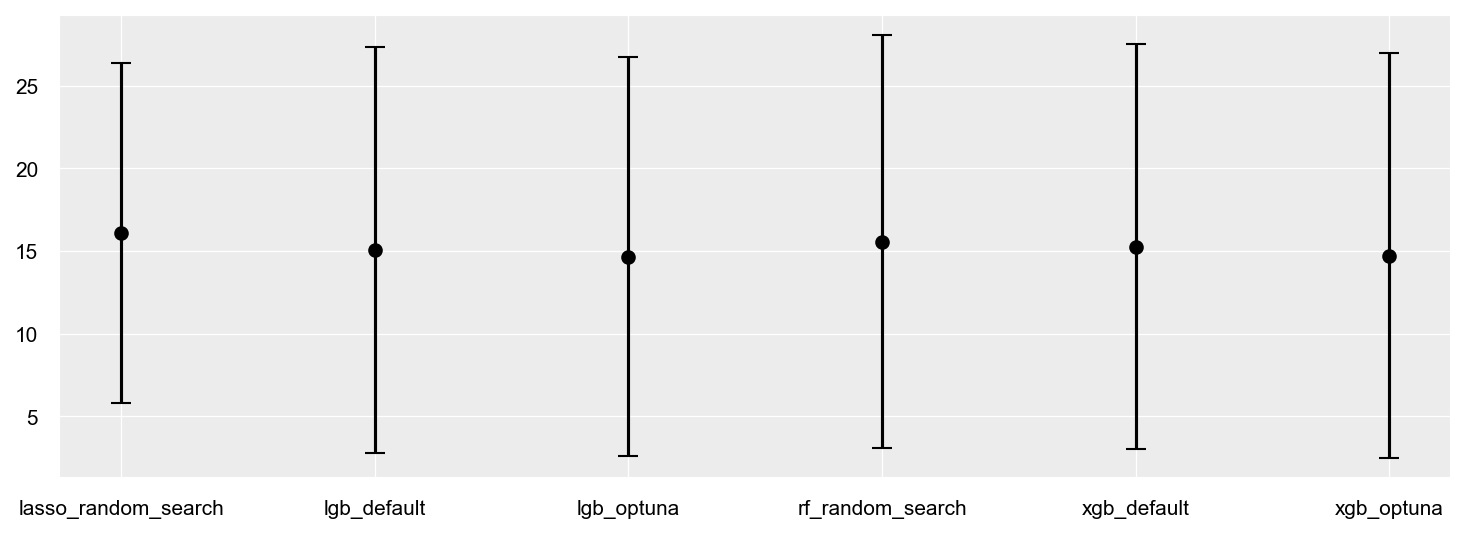

In [46]:
with plt.rc_context(rc = {'figure.dpi': 150, 'axes.labelsize': 10, 
                          'xtick.labelsize': 10, 'ytick.labelsize': 10}):
    
    fig, axes = plt.subplots(2, 1, figsize = (10, 7))
    ax_flat = axes.flatten()

    ax_flat[0].errorbar(optim_results['model_type'], optim_results['rmse_avg'], 
                        yerr=[optim_results['rmse_avg'] - optim_results['Lower'], 
                              optim_results['Upper'] - optim_results['rmse_avg']], 
                        fmt='o', color='black', capsize=5)
    
    ax_flat[1].set_visible(False)

plt.tight_layout()
plt.show()

In [47]:
optim_results.round(2)

model_type  rmse_avg  rmse_std  Lower  Upper
5  lasso_random_search     16.08     10.28   5.80  26.35
2          lgb_default     15.05     12.27   2.78  27.32
3           lgb_optuna     14.66     12.08   2.58  26.74
4     rf_random_search     15.56     12.49   3.06  28.05
0          xgb_default     15.26     12.25   3.01  27.51
1           xgb_optuna     14.72     12.25   2.47  26.98

## II. Testing

### 1. RMSE test set

The analysis of the overall model performance on the test set.

In [48]:
with open(f'{path_project}\\data\\forecast.parquet', 'rb') as handle:
    data = pq.read_table(handle).to_pandas()

data['squared_error'] = (data['pm25_median_forecast'] - data['pm25_median'])**2

In [49]:
# Avg rmse
err_model = data.groupby(['tuning', 'model'], as_index=False)['squared_error'].mean()
err_model['rmse'] = err_model['squared_error']**(1/2)

# Std
err_model_version = data.groupby(['tuning', 'model', 'fc_version'], 
                                 as_index=False)['squared_error'].mean()
err_model_version['rmse'] = err_model_version['squared_error']**(1/2)

err_model_version_std = err_model_version.groupby(['tuning', 'model'], as_index=False)['rmse'].std()
err_model_version_std = err_model_version_std.rename(columns={'rmse': 'rmse_std'})

err_model = err_model.merge(err_model_version_std, how='left', on=['tuning', 'model'])


def model_type(model, tuning):
    if tuning == 'False':
        return 'default'
    elif (model == 'xgb') or (model == 'lgb'):
        return 'optuna'
    else:
        return 'random_search'


# Model type
err_model['model_type'] = [f'{x}_{model_type(x, y)}' for x, y in 
                           zip(err_model['model'], err_model['tuning'])]

err_model['Lower'] = err_model['rmse'] - err_model['rmse_std']
err_model['Upper'] = err_model['rmse'] + err_model['rmse_std']

err_model = err_model.sort_values(by='model_type')

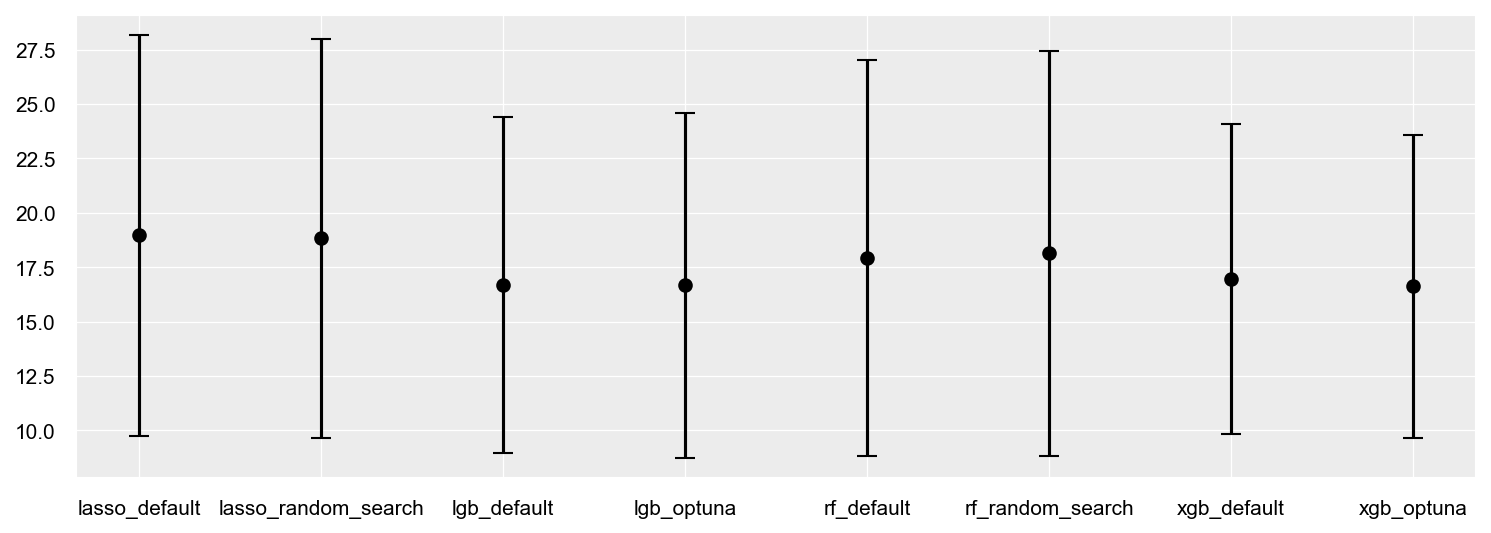

In [50]:
with plt.rc_context(rc = {'figure.dpi': 150, 'axes.labelsize': 10, 
                          'xtick.labelsize': 10, 'ytick.labelsize': 10}):
    
    fig, axes = plt.subplots(2, 1, figsize = (10, 7))
    ax_flat = axes.flatten()

    ax_flat[0].errorbar(err_model['model_type'], err_model['rmse'], 
                        yerr=[err_model['rmse'] - err_model['Lower'], 
                              err_model['Upper'] - err_model['rmse']], 
                        fmt='o', color='black', capsize=5)
    
    ax_flat[1].set_visible(False)

plt.tight_layout()
plt.show()

In [51]:
err_model[['model_type', 'rmse', 'rmse_std', 'Lower', 'Upper']].round(2)

model_type   rmse  rmse_std  Lower  Upper
0        lasso_default  18.96      9.20   9.75  28.16
4  lasso_random_search  18.82      9.17   9.65  27.99
1          lgb_default  16.68      7.71   8.97  24.38
5           lgb_optuna  16.66      7.93   8.72  24.59
2           rf_default  17.92      9.11   8.81  27.03
6     rf_random_search  18.14      9.31   8.83  27.45
3          xgb_default  16.96      7.14   9.82  24.10
7           xgb_optuna  16.62      6.97   9.64  23.59

### 2. RMSE test set (by day)

The analysis of the model performance (broken down by day) on the test set.

In [52]:
err_model_day = data.groupby(['tuning', 'model', 'day_number'], 
                             as_index=False)['squared_error'].mean()
err_model_day['rmse'] = err_model_day['squared_error']**(1/2)

err_model_day['model_type'] = [f'{x}_{model_type(x, y)}' for x, y in 
                               zip(err_model_day['model'], err_model_day['tuning'])]

err_model_day = err_model_day.sort_values(by='model_type')

In [53]:
pd.pivot_table(err_model_day, index=['model_type'], columns='day_number', values='rmse').round(2)

day_number               0      1      2      3      4      5      6
model_type                                                          
lasso_default        11.10  12.61  12.48  11.13  40.66  11.98  12.23
lasso_random_search  10.71  12.98  12.53  10.94  39.87  12.24  13.17
lgb_default           9.59  11.23  10.29   9.97  35.34  11.48  11.68
lgb_optuna            9.25  10.84  10.37  10.16  35.50  11.04  11.84
rf_default           10.83  11.37  10.81   9.90  39.08  10.85  11.59
rf_random_search      9.75  11.82  11.44   9.80  39.79  11.06  11.31
xgb_default           9.76  11.49  11.35  11.18  34.66  12.31  13.15
xgb_optuna            9.41  11.86  11.06  10.42  33.96  11.92  13.09

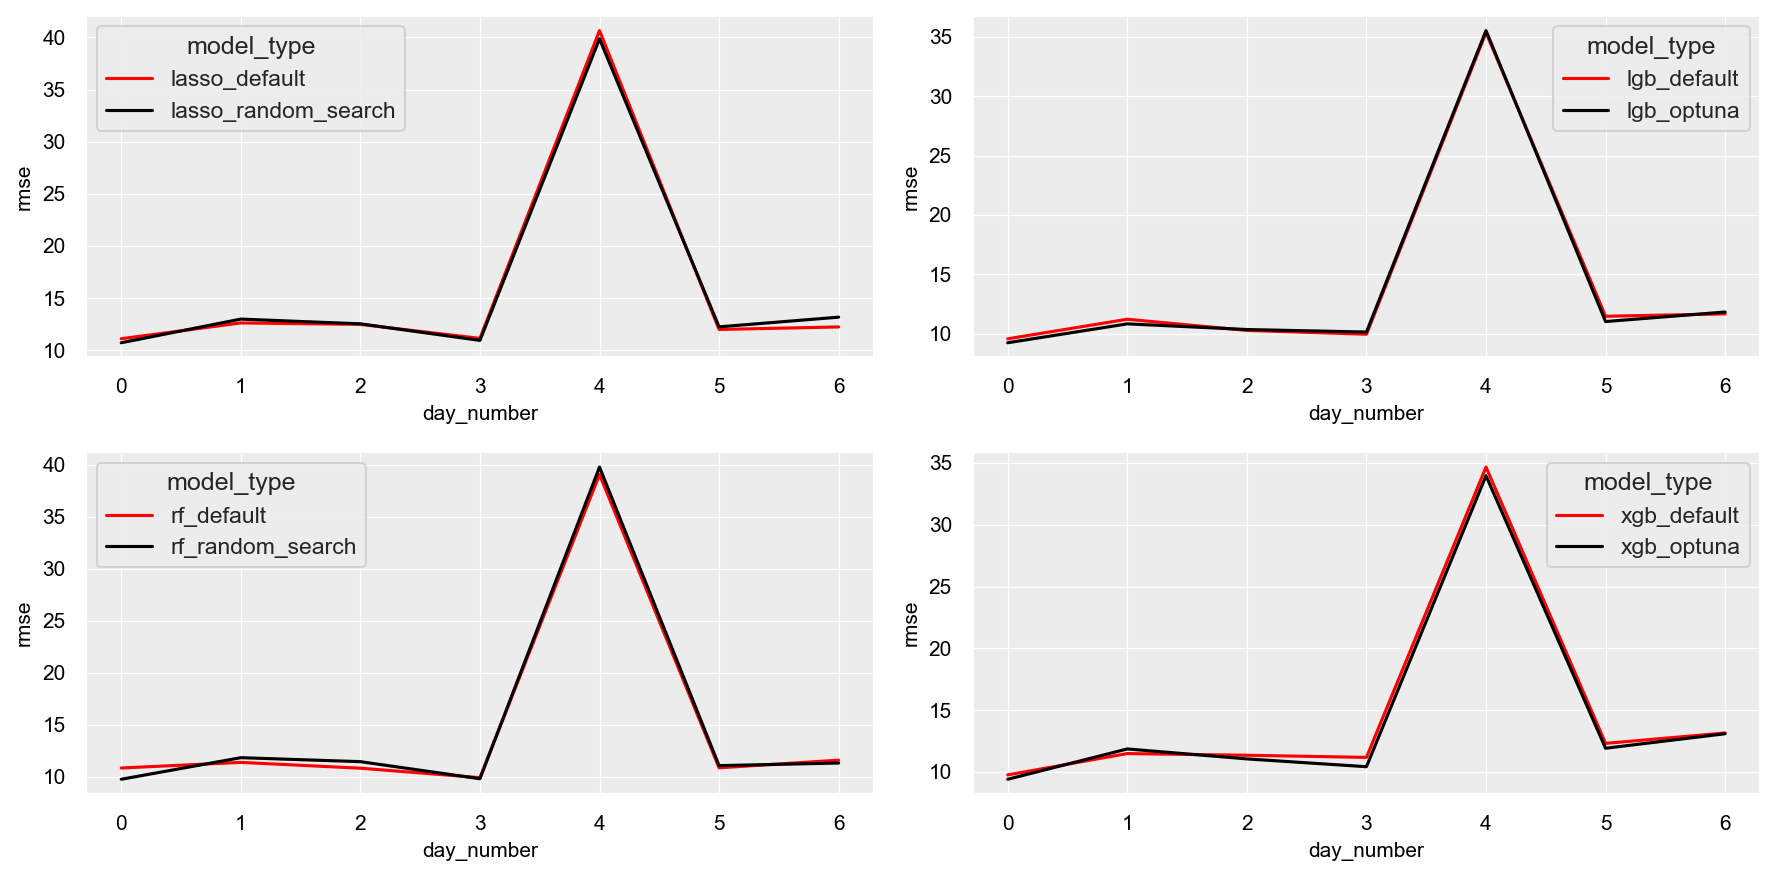

In [54]:
model_types = [err_model_day['model_type'].unique()[x:x+2] for x in range(0, 8, 2)]

with plt.rc_context(rc = {'figure.dpi': 150, 'axes.labelsize': 10, 
                          'xtick.labelsize': 10, 'ytick.labelsize': 10}):
    
    fig, axes = plt.subplots(2, 2, figsize = (12, 6))
    ax_flat = axes.flatten()

    for models, ax in zip(model_types, ax_flat):
        df = err_model_day[err_model_day['model_type'].isin(models)]
        sns.lineplot(ax=ax, x=df['day_number'], palette=['#FF0000', '#000000'],
                     y=df['rmse'], hue=df['model_type'])

plt.tight_layout()
plt.show()

### 3. RMSE test set (exclude spikes)

The analysis of the test error with 2 days (spikes) out of 56 excluded for tuned and default models.

In [55]:
# Avg rmse
err_model_day = data[~data['Date'].isin(['2020-11-09', '2020-12-09'])].groupby(['tuning', 'model'], 
                     as_index=False)['squared_error'].mean()

err_model_day['rmse'] = err_model_day['squared_error']**(1/2)

# Std
err_model_version = data[~data['Date'].isin(['2020-11-09', '2020-12-09'])].groupby(['tuning', 'model', 'fc_version'], 
                         as_index=False)['squared_error'].mean()

err_model_version['rmse'] = err_model_version['squared_error']**(1/2)
err_model_day_std = err_model_version.groupby(['tuning', 'model'], as_index=False)['rmse'].std()
err_model_day_std = err_model_day_std.rename(columns={'rmse': 'rmse_std'})

err_model_day = err_model_day.merge(err_model_day_std, how='left', on=['tuning', 'model'])

# Model type
err_model_day['model_type'] = [f'{x}_{model_type(x, y)}' for x, y in 
                               zip(err_model_day['model'], err_model_day['tuning'])]

err_model_day = err_model_day.sort_values(by='model_type')

err_model_day.round(2)

tuning  model  squared_error   rmse  rmse_std           model_type
0  False  lasso         141.22  11.88      0.98        lasso_default
4   True  lasso         145.42  12.06      1.14  lasso_random_search
1  False    lgb         117.93  10.86      0.64          lgb_default
5   True    lgb         114.22  10.69      0.48           lgb_optuna
2  False     rf         119.17  10.92      0.74           rf_default
6   True     rf         119.24  10.92      1.01     rf_random_search
3  False    xgb         135.85  11.66      0.68          xgb_default
7   True    xgb         130.94  11.44      0.90           xgb_optuna

### 4. Forecast test set (total)

In [56]:
data['model_type'] = [f'{x}_{model_type(x, y)}' for x, y in zip(data['model'], data['tuning'])]
data_gr = data[data['tuning'] == 'True'].groupby(['Date', 'model_type'], 
                                                 as_index=False)[['pm25_median_forecast', 'pm25_median']].sum()

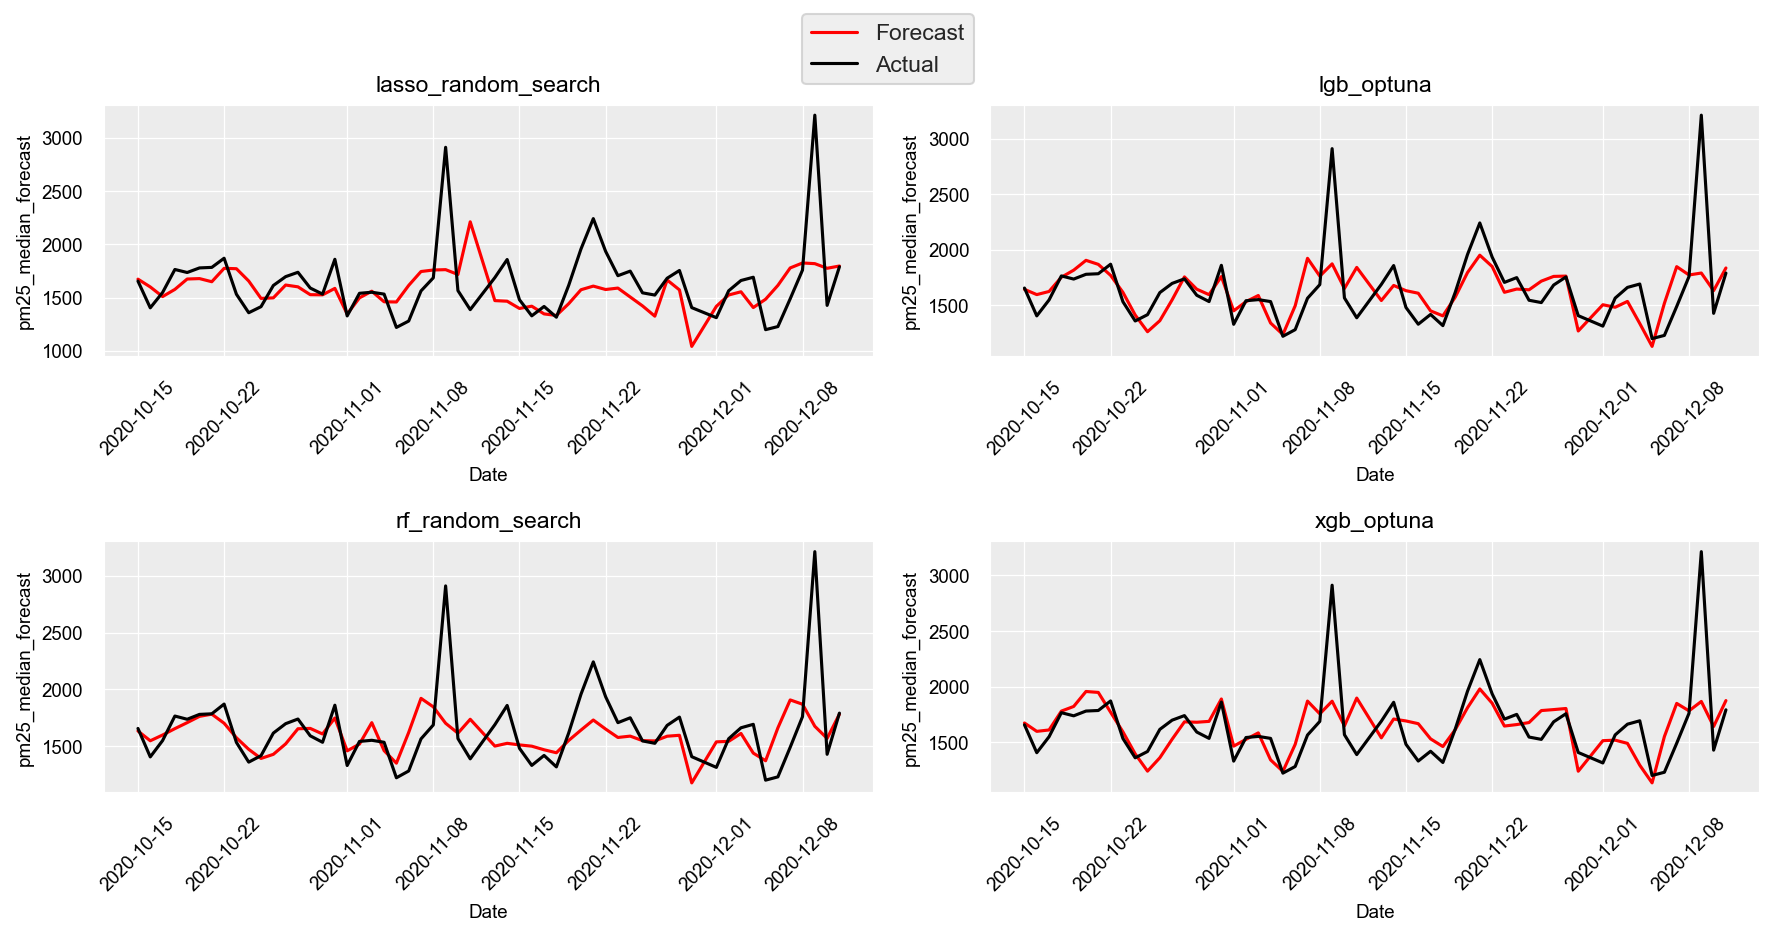

In [57]:
with plt.rc_context(rc = {'figure.dpi': 150, 'axes.labelsize': 9, 
                          'xtick.labelsize': 9, 'ytick.labelsize': 9}):
    
    fig, axes = plt.subplots(2, 2, figsize = (12, 6))
    ax_flat = axes.flatten()

    for model, ax in zip(data_gr['model_type'].unique(), ax_flat):
        df = data_gr[data_gr['model_type'] == model]
        line1 = sns.lineplot(ax=ax, x=df['Date'], y=df['pm25_median_forecast'], color='red')
        line2 = sns.lineplot(ax=ax, x=df['Date'], y=df['pm25_median'], color='black')

        ax.set_title(str(model), fontsize=11, color='black')
        plt.setp(ax.get_xticklabels(), rotation=45)

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend([line1.lines[0], line1.lines[1]], ['Forecast', 'Actual'], 
               loc='upper center', bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.show()

In [58]:
data_gr = data.groupby(['Date', 'day_number', 'model_type'], as_index=False)[['pm25_median_forecast', 'pm25_median']].sum()
data_gr = data_gr[data_gr['model_type'] == 'xgb_optuna']

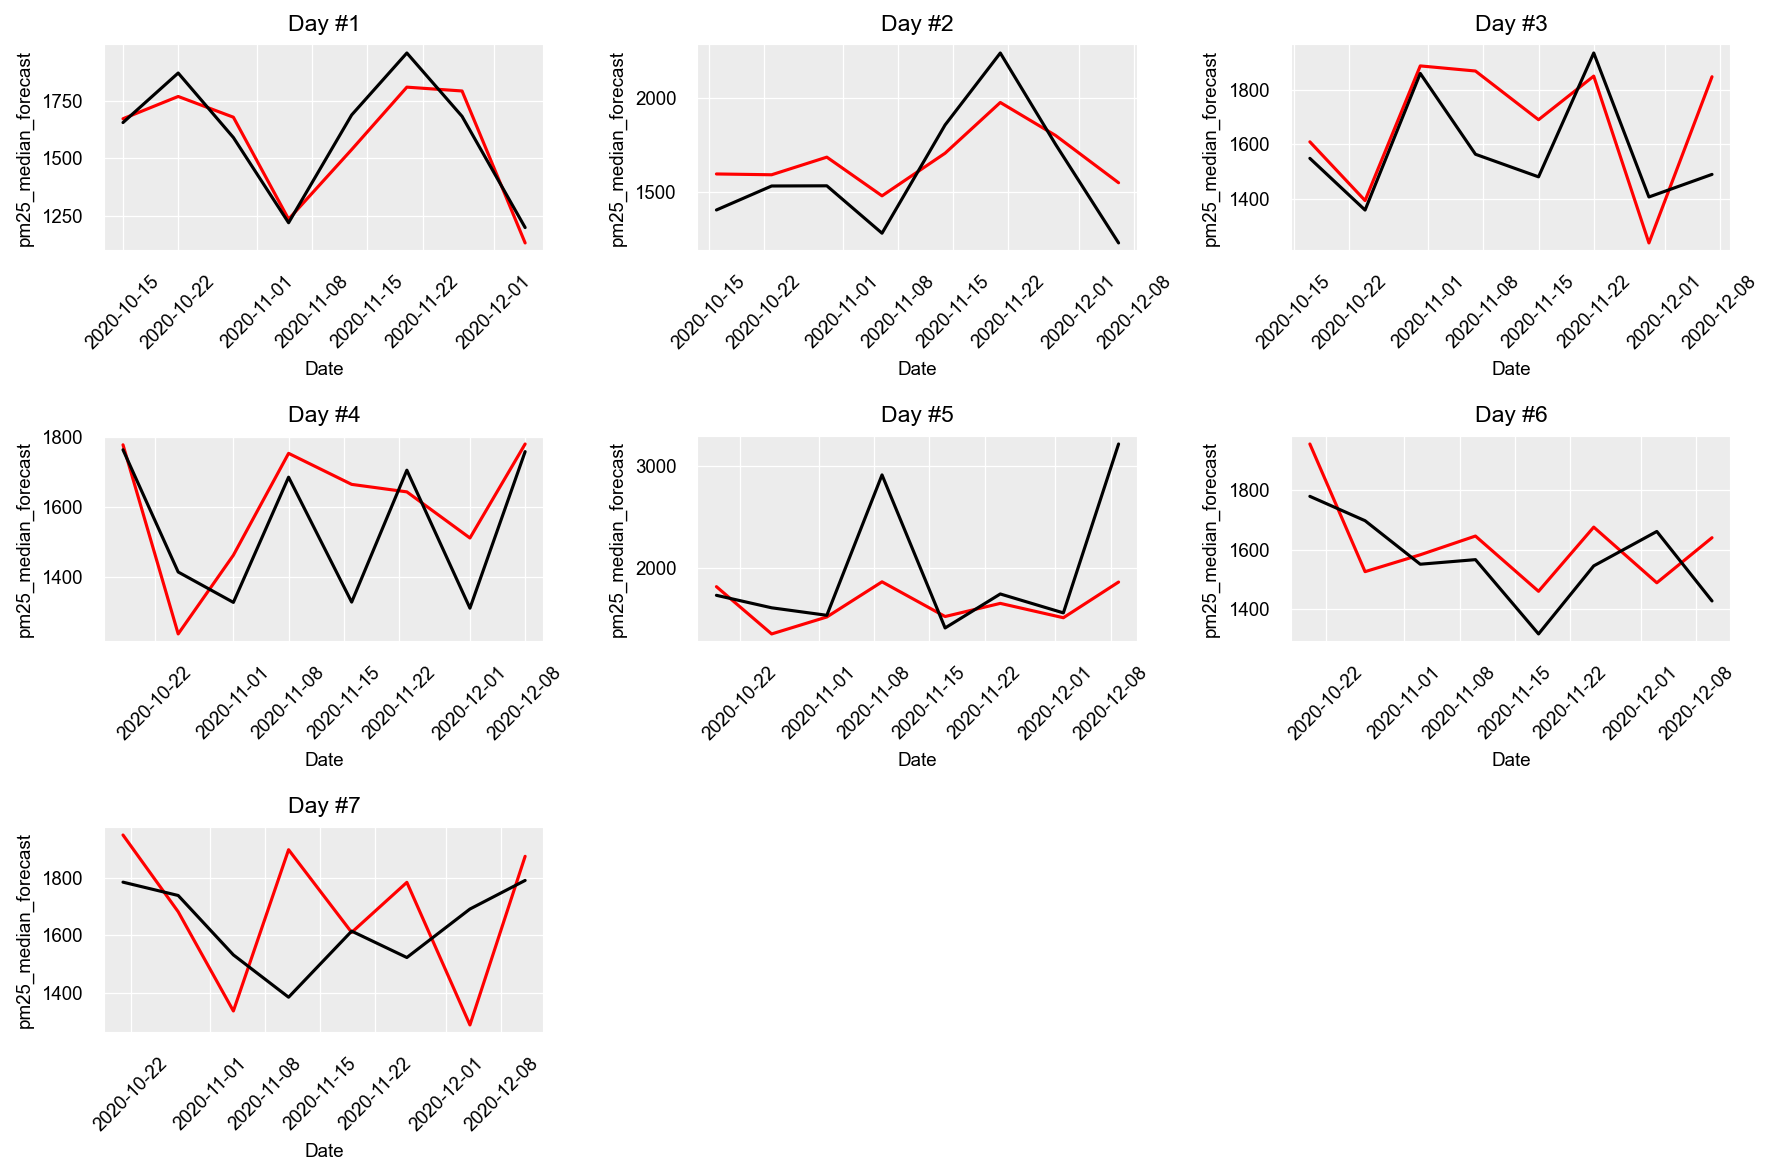

In [59]:
with plt.rc_context(rc = {'figure.dpi': 150, 'axes.labelsize': 9, 
                          'xtick.labelsize': 9, 'ytick.labelsize': 9}):
    
    fig, axes = plt.subplots(3, 3, figsize = (12, 8))
    ax_flat = axes.flatten()

    for idx, (day, ax) in enumerate(zip(data_gr['day_number'].unique(), ax_flat)):
        df = data_gr[data_gr['day_number'] == day]
        sns.lineplot(ax=ax, x=df['Date'], y=df['pm25_median_forecast'], color='red')
        sns.lineplot(ax=ax, x=df['Date'], y=df['pm25_median'], color='black')

        ax.set_title(f'Day #{day + 1}', fontsize=11, color='black')
        plt.setp(ax.get_xticklabels(), rotation=45)
    
    # Removing empty figures
    [axes.set_visible(False) for axes in ax_flat[idx + 1:]]

plt.tight_layout()
plt.show()

### 5. Forecast test set (by city)

In [60]:
data['model_type'] = [f'{x}_{model_type(x, y)}' for x, y in zip(data['model'], data['tuning'])]
data_gr = data[data['model_type'] == 'xgb_optuna'].groupby(['Date', 'City'], 
               as_index=False)[['pm25_median_forecast', 'pm25_median']].sum()

data_gr = data_gr[data_gr['City'].isin(data_gr['City'].unique()[0:6])]

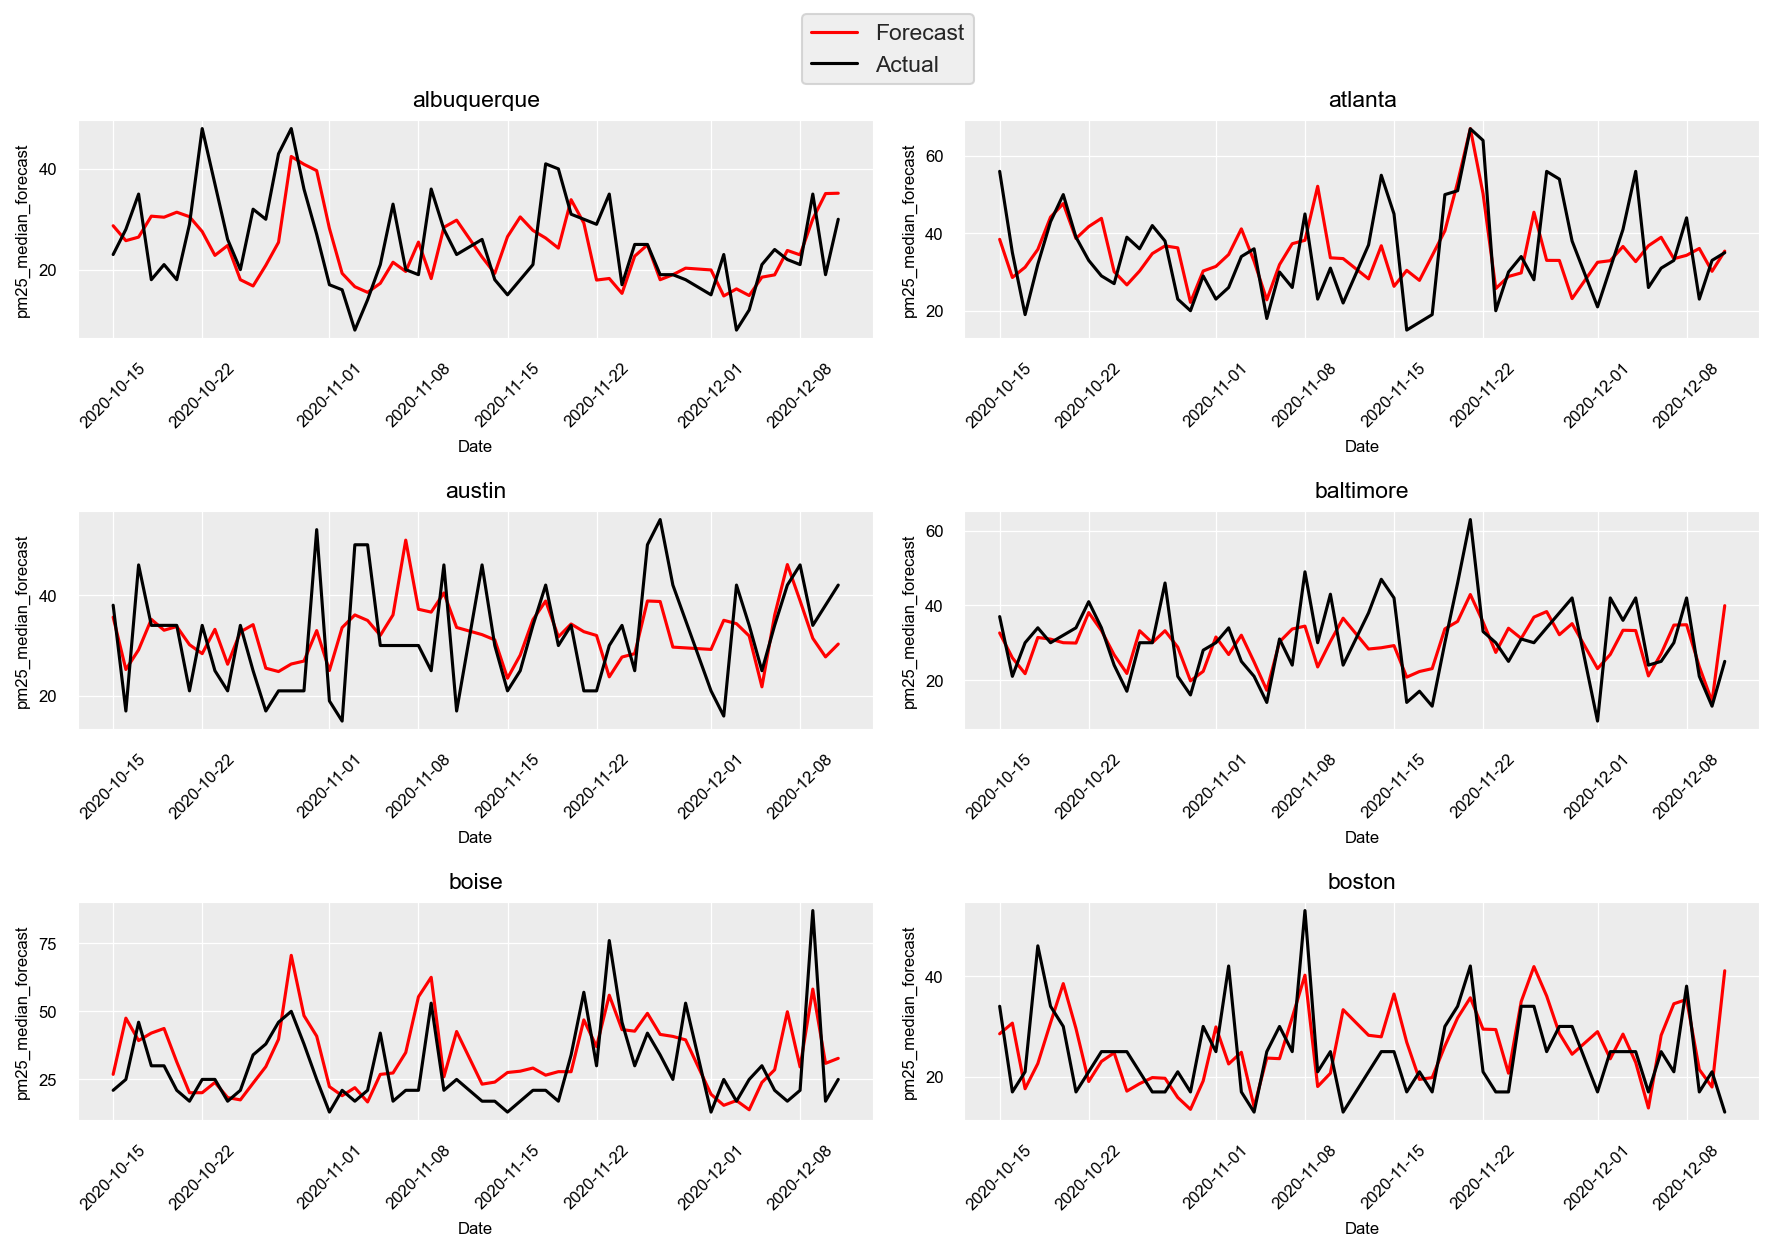

In [61]:
with plt.rc_context(rc = {'figure.dpi': 150, 'axes.labelsize': 8, 
                          'xtick.labelsize': 8, 'ytick.labelsize': 8}):
    
    fig, axes = plt.subplots(3, 2, figsize = (12, 8))
    ax_flat = axes.flatten()

    for model, ax in zip(data_gr['City'].unique(), ax_flat):
        df = data_gr[data_gr['City'] == model]
        line1 = sns.lineplot(ax=ax, x=df['Date'], y=df['pm25_median_forecast'], color='red')
        line2 = sns.lineplot(ax=ax, x=df['Date'], y=df['pm25_median'], color='black')

        ax.set_title(str(model), fontsize=11, color='black')
        plt.setp(ax.get_xticklabels(), rotation=45)

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend([line1.lines[0], line1.lines[1]], ['Forecast', 'Actual'], 
               loc='upper center', bbox_to_anchor=(0.5, 1.05))


plt.tight_layout()
plt.show()

### 6. SHAP

In [62]:
with open(f'{path_project}\\data\\shap_lgb.parquet', 'rb') as handle:
    shap_lgb = pq.read_table(handle).to_pandas()

choose_city = 'atlanta'
shap_lgb = shap_lgb[shap_lgb['City'] == choose_city].rename(columns={'pm25_median': 'pm25_median_forecast'})
shap_lgb['expected_value'] = 30.87
actual = data[(data['model_type'] == 'lgb_optuna') & (data['City'] == choose_city)][['Date', 'City', 'pm25_median']]
shap_lgb = shap_lgb.merge(actual, how='left', on=['Date', 'City'])
shap_lgb_melt = pd.melt(shap_lgb, id_vars=['Date', 'City', 'day_number', 'model', 'fc_version'])
shap_vars = shap_lgb_melt[shap_lgb_melt['variable'].isin(['temperature_max', 'lag_1', 'wind-gust_max'])]
fc_actual = shap_lgb_melt[shap_lgb_melt['variable'].isin(['pm25_median', 'pm25_median_forecast', 'expected_value'])]

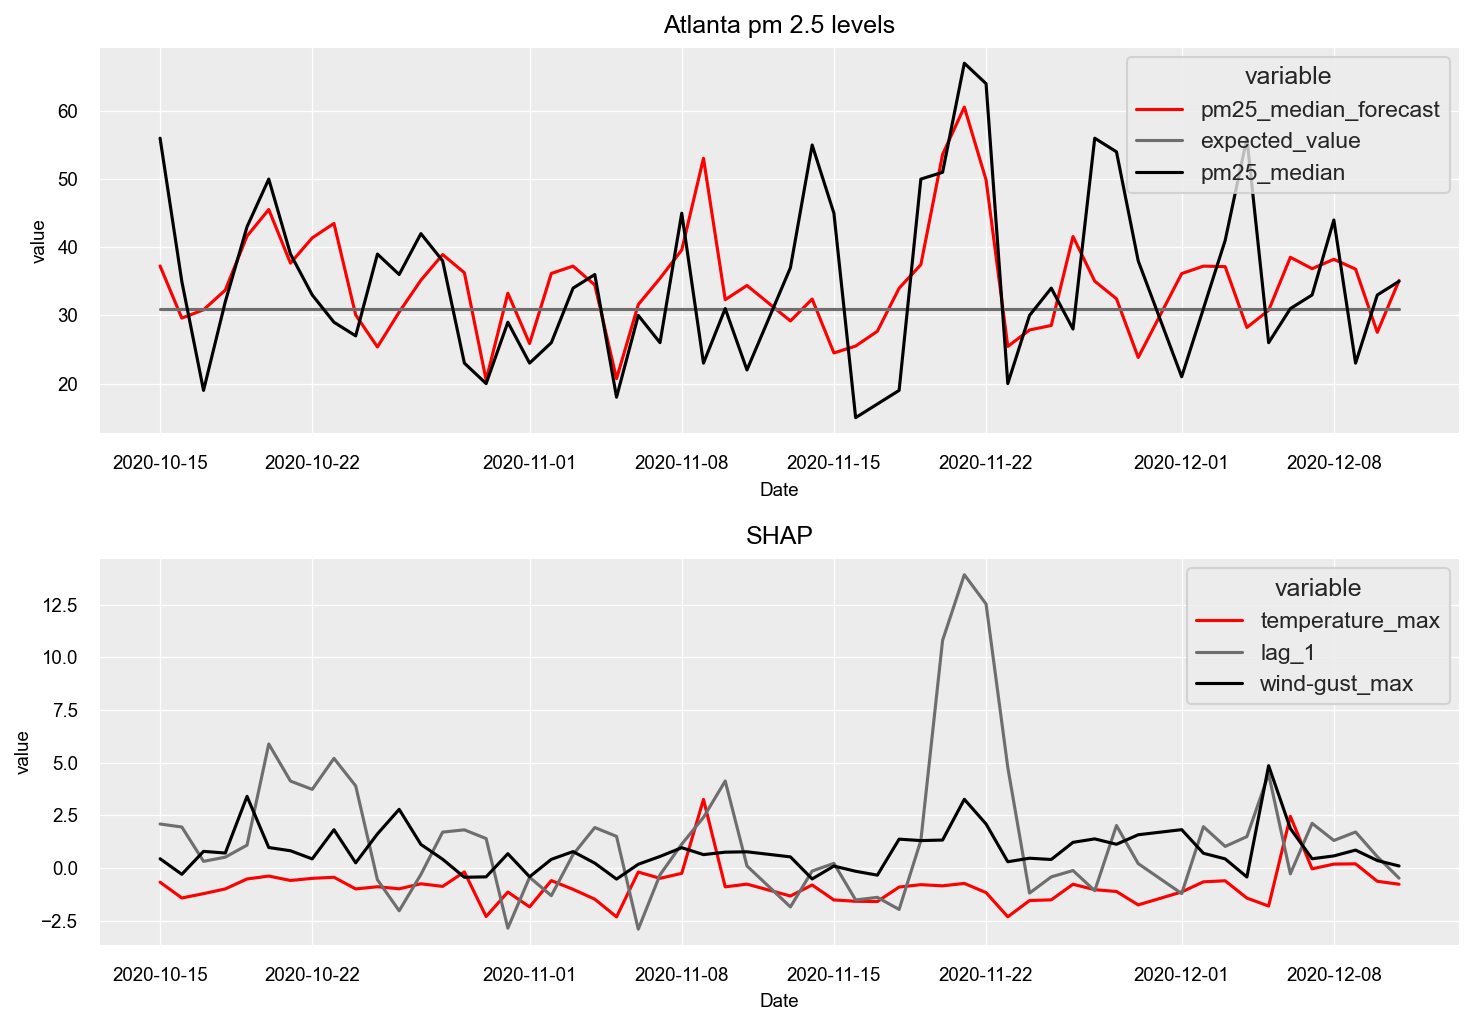

In [63]:
with plt.rc_context(rc = {'figure.dpi': 150, 'axes.labelsize': 9, 
                          'xtick.labelsize': 9, 'ytick.labelsize': 9}):
    
    fig, axes = plt.subplots(2, 1, figsize = (10, 7))
    ax_flat = axes.flatten()

    sns.lineplot(ax=ax_flat[0], x=fc_actual['Date'], y=fc_actual['value'], hue=fc_actual['variable'],
                 palette=['#FF0000', '#6e6e6e', 'black'])
    
    sns.lineplot(ax=ax_flat[1], x=shap_vars['Date'], y=shap_vars['value'], hue=shap_vars['variable'],
                 palette=['#FF0000', '#6e6e6e', 'black'])
    
    ax_flat[0].set_title('Atlanta pm 2.5 levels', fontsize=12, color='black')
    ax_flat[1].set_title('SHAP', fontsize=12, color='black')

plt.tight_layout()
plt.show()